In [14]:
import sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import os
import math
from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from numpy import where
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from keras.datasets import imdb
from keras import preprocessing

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, GRU,Bidirectional,Conv1D,MaxPooling1D,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.layers import LSTM
from keras.optimizers import RMSprop
import statsmodels.api as sm
from scipy.integrate import simps

# check version number
import imblearn
font = {'family' : 'normal','size'   : 20}
plt.rc('font', **font)
plt.rc('figure', titlesize=16)

In [15]:
testDays=np.array([[datetime(2018,7,20),datetime(2018,7,13),datetime(2018,7,27),datetime(2018,7,10),datetime(2018,6,22),datetime(2018,7,3),datetime(2018,7,17),datetime(2018,6,25),datetime(2018,7,24)],
           [datetime(2018,7,19),datetime(2018,6,28),datetime(2018,7,20),datetime(2018,7,27),datetime(2018,7,3),datetime(2018,6,22),datetime(2018,7,26),datetime(2018,6,29),datetime(2018,7,13)],
           [datetime(2018,8,16),datetime(2018,8,8),datetime(2018,8,10),datetime(2018,7,30),datetime(2018,8,20),datetime(2018,8,3),datetime(2018,8,1),datetime(2018,8,17),datetime(2018,8,15)],
           [datetime(2018,8,28),datetime(2018,8,15),datetime(2018,8,14),datetime(2018,8,29),datetime(2018,8,20),datetime(2018,8,22),datetime(2018,8,27),datetime(2018,8,21),datetime(2018,8,16)],
           [datetime(2018,9,6),datetime(2018,9,13),datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,20),datetime(2018,9,11),datetime(2018,9,17),datetime(2018,9,5),datetime(2018,9,4)],
           [datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,25),datetime(2018,9,13),datetime(2018,10,3),datetime(2018,10,2),datetime(2018,9,27),datetime(2018,9,17),datetime(2018,9,26)],
           [datetime(2018,10,4),datetime(2018,10,9),datetime(2018,9,25),datetime(2018,10,11),datetime(2018,9,26),datetime(2018,10,3),datetime(2018,10,10),datetime(2018,9,27),datetime(2018,10,2)]
           ]).astype(datetime)

testDaysMealNumbers=np.zeros((7,9,2))
for i in range(7):
    for j in range(9):
        tempDay=testDays[i,j]
        testDaysMealNumbers[i,j,0]=tempDay.timetuple().tm_yday
        testDaysMealNumbers[i,j,1]=j

In [16]:
#Separating the test days from normal ones
def dataSanitizer(rootAddressAllData,rootAddressSanitized):
    os.chdir(rootAddressAllData)
    patientName=['38A','38B','38C','38D','38E','38F','38H']
    fileNames=os.listdir()

    for fileName in fileNames:
        for counter in range(7):
            if(patientName[counter] in fileName):
                currentPatient=counter
                break
        print(fileName)
        myDf=pd.read_csv(fileName)
        for myColumn in myDf.columns:
            if myColumn not in ['time','BG','Participant']:
                del myDf[myColumn]
        myDf=myDf.dropna()
        myDf=myDf.drop_duplicates(subset=['time'], keep='last')
        myDf['time']= pd.to_datetime(myDf['time'])

        myDf.insert(3,"StandardTest",0)
        for rowCounter in range(0,len(myDf)):
            for counter in range(0,9):
                if myDf.iloc[rowCounter,1].date()==testDays[currentPatient][counter].date():
                    myDf.iloc[rowCounter,3]=counter+1
                    break

        myDf=myDf[myDf.StandardTest > 0]
        myFileAddress=rootAddressSanitized+patientName[currentPatient]+'.csv'
        myDf.to_csv(myFileAddress,index = False)

rootAddressAllData=r'C:\GitHub\STMI-CGM\Selected-38'
rootAddressSanitized=r'C:\GitHub\STMI-CGM\Sanitized38\TestDays_'
dataSanitizer(rootAddressAllData,rootAddressSanitized)

overall_spread_sheet_38A.csv
overall_spread_sheet_38B.csv
overall_spread_sheet_38C.csv
overall_spread_sheet_38D.csv
overall_spread_sheet_38E.csv
overall_spread_sheet_38F.csv
overall_spread_sheet_38H.csv


In [17]:
#------------AMIN PLEASE IMPLEMNET THE LOGISTIC REGRESSION AND SVM HERE USING THE SAME FORMAT FOR THE HYPERPARAMETERS-------------

#Setting Random Forest algorithm and testing all hyper-parameters
def STMI_random_forest(trains_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_tree_number=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for threshold_counter in np.arange(0.4,0.8,0.2):
        threshold_counter=round(threshold_counter,2)
        for tree_number_counter in np.arange(3,10):
            for max_depth_counter in np.arange(3,10):
                for positive_weight_counter in np.arange(1,4,0.5):
                    treeNumber=tree_number_counter
                    maxDepth=max_depth_counter
                    positive_weight=0.2*10**positive_weight_counter

                    clf=RandomForestClassifier(n_estimators=treeNumber,criterion='entropy',random_state=0,max_depth=maxDepth,class_weight={0: 1, 1: positive_weight})
                    clf.fit(trains_data_func,train_labels_func)
                    sliddingWindowPrediction=clf.predict_proba(test_data_func)
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold_counter]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold_counter]=0

                    confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction)
                    accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction)
                    recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction)

                    if(accuracy_score_value>=best_accuracy and recall_score_value>=best_recall):
                        best_accuracy=accuracy_score_value
                        best_recall=recall_score_value
                        best_tree_number=treeNumber
                        best_positive_weight=positive_weight
                        best_max_depth=maxDepth
                        best_confusion_matrix=confusionMatrix
                        best_threshold=threshold_counter
                        best_model=clf


    best_confusion_matrix=[['\t','Pred Neg\t','Pred Pos'],['Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\RF"+patient_name_func+".pkl"
    pickle.dump(clf, open(file_name, "wb"))

    return best_model,best_threshold,best_tree_number,best_max_depth,best_positive_weight,best_confusion_matrix

In [18]:
#Setting XGBoost algorithm and testing all hyper-parameters
def STMI_XGBoost(train_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_eta=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for threshold_counter in np.arange(0.4,0.8,0.2):
        threshold_counter=round(threshold_counter,2)
        for eta_counter in np.arange(0.05,0.50,0.05):
            for max_depth_counter in np.arange(3,10):
                for positive_weight_counter in np.arange(1,4,0.5):
                    eta_value=eta_counter
                    maxDepth=max_depth_counter
                    positive_weight=0.2*10**positive_weight_counter

                    model = XGBClassifier(eta=eta_value,max_depth=maxDepth,scale_pos_weight=positive_weight,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False)
                    model.fit(train_data_func, train_labels_func)
                    sliddingWindowPrediction = model.predict_proba(test_data_func)
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold_counter]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold_counter]=0

                    confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction)
                    accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction)
                    recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction)

                    if accuracy_score_value>=best_accuracy and recall_score_value>=best_recall:
                        best_accuracy=accuracy_score_value
                        best_recall=recall_score_value
                        best_eta=eta_value
                        best_positive_weight=positive_weight
                        best_max_depth=maxDepth
                        best_confusion_matrix=confusionMatrix
                        best_threshold=threshold_counter
                        best_model=model
        
    best_confusion_matrix=[['\t','Pred Neg\t','Pred Pos'],['Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\XG"+patient_name_func+".pkl"
    pickle.dump(best_model, open(file_name, "wb"))
    return best_model,best_threshold,best_eta,best_max_depth,best_positive_weight,best_confusion_matrix

In [48]:
#Finding the fasting blood glucose value for each day
def fastingBGFinder(query,currentDay):
    fastingBG=80.0001
    fastingQuery=query[query['Time']>=3]
    fastingQuery=fastingQuery[fastingQuery['Time']<=6]

    if(not np.isnan(fastingQuery.BG.mean())):
        fastingBG=fastingQuery.BG.mean()
    else:
        print("The BG base line is not found for",currentDay,"and we used 80.0001")
    return fastingBG

#Calculating the statistics for each slidding window
def statCalculator(query,baseLine):
    integralValue=simps(query.iloc[:,3]-baseLine,x=query.iloc[:,2])

    maxSlopeValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    maxSlopeValue=np.max(maxSlopeValue)

    minSlopeValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    minSlopeValue=np.min(minSlopeValue)

    pointNum=len(query)-1
    if query.iloc[int(pointNum/2),2]==query.iloc[0,2]:
        print(query)
        sys.exit('The window qurery is not big enough. The minimum window duration should be more than 1 hour')

    firstHalfSlope=query.iloc[int(pointNum/2),3]-query.iloc[0,3]
    firstHalfSlope/=query.iloc[int(pointNum/2),2]-query.iloc[0,2]

    secondHalfSlope=query.iloc[pointNum,3]-query.iloc[int(pointNum/2),3]
    secondHalfSlope/=query.iloc[pointNum,2]-query.iloc[int(pointNum/2),2]

    maxConcavityValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    maxConcavityValue=np.gradient(maxConcavityValue,query.iloc[:,2])
    maxConcavityValue=np.max(maxConcavityValue)

    minConcavityValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    minConcavityValue=np.gradient(minConcavityValue,query.iloc[:,2])
    minConcavityValue=np.min(minConcavityValue)

    meanValue=query['BG'].mean()-baseLine
    stdValue=query['BG'].std()
    minValue=query['BG'].min()-baseLine
    maxValue=query['BG'].max()-baseLine

    return meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,firstHalfSlope,secondHalfSlope,integralValue,minConcavityValue,maxConcavityValue

#Chopping the data into daily values and forming the sliddingWindow
def sliddingWindowMaker(allDays,rawData,testDayFlag):
    sliddingWindow=[]
    sliddingWindowLabel=[]
    for dayCounter in range(len(allDays)):
        currentDay=allDays[dayCounter]
        dayQuery=rawData[rawData['Day of Year']==currentDay]
        startTime=dayQuery.iloc[0,2]
        endTime=startTime+timeWindow
        fastingBG=fastingBGFinder(dayQuery,currentDay)

        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]
        while len(windowQuery)>=(timeWindow*4/2):
            if endTime>17 and testDayFlag:
                break #after 4PM the participants go home and they don't hold the criteria anymore
            if startTime<=breakfastTime and endTime>=breakfastTime:
                eatFlag=1
            else:
                eatFlag=0
            statInfo=statCalculator(windowQuery,fastingBG)
            statInfo=list(statInfo)
            statInfo.extend([startTime,endTime,currentDay])
            sliddingWindow.append(statInfo)
            sliddingWindowLabel.append(eatFlag)

            startTime+=timeStep
            endTime+=timeStep
            windowQuery=dayQuery[dayQuery['Time']>=startTime]
            windowQuery=windowQuery[windowQuery['Time']<endTime]
    return sliddingWindow,sliddingWindowLabel

#Reading the CSV for each participant and calculating the day of year and time (decimal format)
def csvReader(csvAddress,testDayFlag):
    rawData=pd.read_csv(csvAddress)
    for myColumn in rawData.columns:
        if myColumn not in ['time','BG','Participant']:
            del rawData[myColumn]

    rawData['time']= pd.to_datetime(rawData['time'])
    rawData['BG']= pd.to_numeric(rawData['BG'])

    rawData=rawData.dropna()
    rawData=rawData.drop_duplicates(subset=['time'], keep='last')

    rawData.insert(2, "Day of Year",rawData['time'].dt.dayofyear)
    rawData.insert(3, "Time",rawData['time'].dt.hour+
                   rawData['time'].dt.minute/60+rawData['time'].dt.second/3600)
    rawData=rawData.drop(columns=['time'])
    rawData=rawData.sort_values(['Day of Year', 'Time'], ascending=[True, True])

    allDays=rawData['Day of Year'].tolist()
    allDays=set(allDays)
    allDays=list(allDays)
    sliddingWindow,sliddingWindowLabel=sliddingWindowMaker(allDays,rawData,testDayFlag)
    return sliddingWindow,sliddingWindowLabel,rawData

#Splitting the data into train and test
def dataSplitter(sliddingWindow,sliddingWindowLabel):
    balancedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=2)
    for trainIndex, testIndex in balancedSplit.split(sliddingWindow, sliddingWindowLabel):
        trainData, testData = sliddingWindow[trainIndex,:], sliddingWindow[testIndex,:]
        trainLabel, testLabel = sliddingWindowLabel[trainIndex], sliddingWindowLabel[testIndex]
    return trainData,testData,trainLabel,testLabel

#Calculating confusion matrix and the model metrics
def resultInterpreter(modelType,modelResult):
    if modelType=='RF':
        bestModel=modelResult[0]
        bestThreshold=modelResult[1]
        bestTreeNumber=modelResult[2]
        bestMaxDepth=modelResult[3]
        bestPositiveWeight=modelResult[4]
        bestConfusionMatrix=modelResult[5]

    if modelType=='XG':
        bestModel=modelResult[0]
        bestThreshold=modelResult[1]
        bestEta=modelResult[2]
        bestMaxDepth=modelResult[3]
        bestPositiveWeight=modelResult[4]
        bestConfusionMatrix=modelResult[5]
    for r in bestConfusionMatrix:
        for c in r:
            print(c,end = " ")
        print("\n")

    specificityMet=int(bestConfusionMatrix[1][1])/(int(bestConfusionMatrix[1][1])+int(bestConfusionMatrix[1][2]))
    specificityMet=round(specificityMet*100,1)

    sensitivityMet=int(bestConfusionMatrix[2][2])/(int(bestConfusionMatrix[2][1])+int(bestConfusionMatrix[2][2]))
    sensitivityMet=round(sensitivityMet*100,1)

    accuracyMet=(int(bestConfusionMatrix[1][1])+int(bestConfusionMatrix[2][2]))/(int(bestConfusionMatrix[1][1])
                                                                                 +int(bestConfusionMatrix[1][2])+int(bestConfusionMatrix[2][1])+int(bestConfusionMatrix[2][2]))
    accuracyMet=round(accuracyMet*100,1)

    print("Specificity=",specificityMet,"Sensitivity=",sensitivityMet,"Accuracy=",accuracyMet)
    return np.round(bestModel.feature_importances_*100,1)

#Balacing the sliddingWindow data using SMOTE
def dataBalancer(sliddingWindow,sliddingWindowLabel):
    oversample = SMOTE()
    sliddingWindowSMOTE, sliddingWindowLabelSMOTE = oversample.fit_resample(sliddingWindow, sliddingWindowLabel)
    return sliddingWindowSMOTE, sliddingWindowLabelSMOTE

#Plotting the BG time-series and the binary classification results on top of that
def windowVisualizer(rawData,bestModel,bestThreshold,testMealNum,patientName,sliddingWindow, sliddingWindowLabel, startTime,endTime,days):
    mealContent=['C1P1F1','C2P2F2','C3P3F3',
                 'C1P2F2','C3P2F2','C2P3F2',
                 'C2P1F2','C2P2F3','C2P2F1']
    allDays=set(days)
    allDays=list(allDays)
    for dayCounter in range(len(allDays)):
        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==allDays[dayCounter]]

        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 26, 4))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(sliddingWindow.shape[0]):
            if days[counter]==allDays[dayCounter]:
                tempData.append(sliddingWindow[counter,:])
                tempLabel.append(sliddingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        if len(tempData)==0:
            sys.exit(("--------Warning, the slidding window is empty for prediction on day:"+allDays[dayCounter]))

        tempPred=bestModel.predict_proba(tempData)
        tempPred=tempPred[:,1]
        tempPred[tempPred>=bestThreshold]=1
        tempPred[tempPred<bestThreshold]=0

        ax2 = ax1.twinx()
        for counter in range(len(tempPred)):
            if tempPred[counter]==tempLabel[counter]:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='b')
            else:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='r')
        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Miss-Classified')
        ax2.plot([],[],linestyle='--', marker='o', color='b',label='Correctly Classified')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.legend()
        for counter in range(9):
            if testMealNum[counter,0]==allDays[dayCounter]:
                tempMealName=testMealNum[counter,1]
        tempMealName=int(tempMealName)
        tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
        tempDate=tempDate.strftime("%b %d")
        plt.title(patientName+"-Day="+tempDate+"-"+mealContent[tempMealName]+
                  "(Meal "+str(tempMealName+1)+")",color='black')

        color='tab:blue'
        ax2.set_ylabel('Eat Flag', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 26, 4))

        plt.grid()
        plt.show()

#1)Reading the participant CSV data, 2)Calling the sliddingWindowMaker, 3)Calling dataBalancer, 4)Calling dataSplitter,
# 5)Calling RF model, 6)Calling windowVisualizer
def participantReader(folderAddress,plotFlag,modelingMethod):
    os.chdir(folderAddress)
    fileNames=os.listdir(folderAddress)
    featureImportance=[]
    for fileName in fileNames:
        if('.pkl' in fileName):
            continue;
        print('Reading.....',fileName)
        if (fileName=='TestDays_38A.csv'):
            patientName='38A'
            testMealNum=testDaysMealNumbers[0,:,:]
        if (fileName=='TestDays_38B.csv'):
            patientName='38B'
            testMealNum=testDaysMealNumbers[1,:,:]
        if (fileName=='TestDays_38C.csv'):
            patientName='38C'
            testMealNum=testDaysMealNumbers[2,:,:]
        if (fileName=='TestDays_38D.csv'):
            patientName='38D'
            testMealNum=testDaysMealNumbers[3,:,:]
        if (fileName=='TestDays_38E.csv'):
            patientName='38E'
            testMealNum=testDaysMealNumbers[4,:,:]
        if (fileName=='TestDays_38F.csv'):
            patientName='38F'
            testMealNum=testDaysMealNumbers[5,:,:]
        if (fileName=='TestDays_38H.csv'):
            patientName='38H'
            testMealNum=testDaysMealNumbers[6,:,:]

        sliddingWindow,sliddingWindowLabel,rawData=csvReader(fileName,True)
        sliddingWindow=np.array(sliddingWindow,dtype=float)
        sliddingWindowLabel=np.array(sliddingWindowLabel,dtype=int)
        sliddingWindowSMOTE,sliddingWindowLabelSMOTE= dataBalancer(sliddingWindow[:,0:11],sliddingWindowLabel)
        trainData,testData,trainLabel,testLabel=dataSplitter(sliddingWindowSMOTE,sliddingWindowLabelSMOTE)
        if modelingMethod=='RF':
            modelResult=STMI_random_forest(trainData,testData,trainLabel,testLabel,patientName)
            featureImportance.append(resultInterpreter('RF',modelResult))
        if modelingMethod=='XG':
            modelResult=STMI_XGBoost(trainData,testData,trainLabel,testLabel,patientName)
            featureImportance.append(resultInterpreter('XG',modelResult))
        if plotFlag:
            windowVisualizer(rawData,modelResult[0],modelResult[1],testMealNum,patientName,sliddingWindow[:,0:11],sliddingWindowLabel,sliddingWindow[:,11],sliddingWindow[:,12],sliddingWindow[:,13])
    featureImportance=np.asarray(featureImportance,dtype=float)
    featureImportance=np.mean(featureImportance,axis=0)
    featureImportance=np.round(featureImportance,2)
    feat_labels = ['Average','STD','Min','Max','Min Slope', 'Max Slope','1st half slope','2nd half slope','Integral Value','Min Concavity','Max Concavity']
    print("The importance of each feature is shown below (the averaged value of all cases)")
    for feature in zip(feat_labels,featureImportance):
        print(feature)

rootAddress=r"C:\GitHub\STMI-CGM\Sanitized38"
timeWindow=90/60
timeStep=30/60
breakfastTime=8
plotFlag=False
modelingMethod='RF'#XG,RF
participantReader(rootAddress,plotFlag,modelingMethod)

Reading..... TestDays_38A.csv
The BG base line is not found for 176 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 56		 15 

Pos	 0		 71 

Specificity= 78.9 Sensitivity= 100.0 Accuracy= 89.4
Reading..... TestDays_38B.csv
The BG base line is not found for 200 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 59		 4 

Pos	 0		 63 

Specificity= 93.7 Sensitivity= 100.0 Accuracy= 96.8
Reading..... TestDays_38C.csv
The BG base line is not found for 220 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 67		 5 

Pos	 0		 71 

Specificity= 93.1 Sensitivity= 100.0 Accuracy= 96.5
Reading..... TestDays_38D.csv
	 Pred Neg	 Pred Pos 

Neg	 73		 3 

Pos	 2		 74 

Specificity= 96.1 Sensitivity= 97.4 Accuracy= 96.7
Reading..... TestDays_38E.csv
	 Pred Neg	 Pred Pos 

Neg	 74		 2 

Pos	 0		 76 

Specificity= 97.4 Sensitivity= 100.0 Accuracy= 98.7
Reading..... TestDays_38F.csv
	 Pred Neg	 Pred Pos 

Neg	 68		 8 

Pos	 0		 76 

Specificity= 89.5 Sensitivity= 100.0 Accuracy= 94.7
Reading..... TestDays_38H.cs

Reading..... 38A
The BG base line is not found for 171 and we used 80.0001
The BG base line is not found for 176 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 1203		 283 

Pos	 57		 44 

Specificity= 81.0 Sensitivity= 43.6 Accuracy= 78.6
Reading..... 38B
The BG base line is not found for 200 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 1245		 246 

Pos	 60		 49 

Specificity= 83.5 Sensitivity= 45.0 Accuracy= 80.9
Reading..... 38C
The BG base line is not found for 220 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 889		 160 

Pos	 30		 42 

Specificity= 84.7 Sensitivity= 58.3 Accuracy= 83.1
Reading..... 38D
The BG base line is not found for 225 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 635		 66 

Pos	 19		 29 

Specificity= 90.6 Sensitivity= 60.4 Accuracy= 88.7
Reading..... 38E
The BG base line is not found for 243 and we used 80.0001
The BG base line is not found for 253 and we used 80.0001
	 Pred Neg	 Pred Pos 

Neg	 660		 61 

Pos	 22		 46 

Specificity= 91.5 Sensitivity=

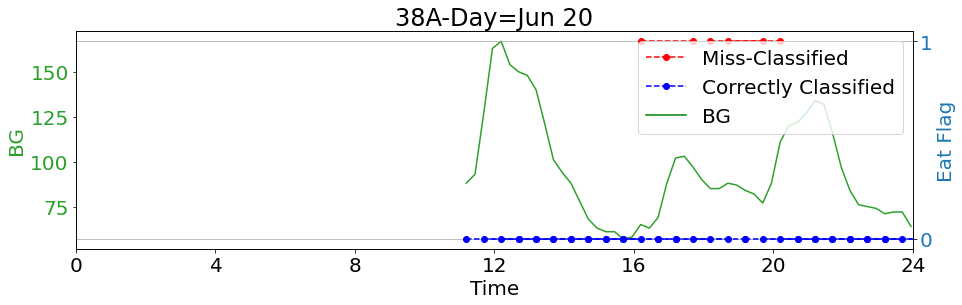

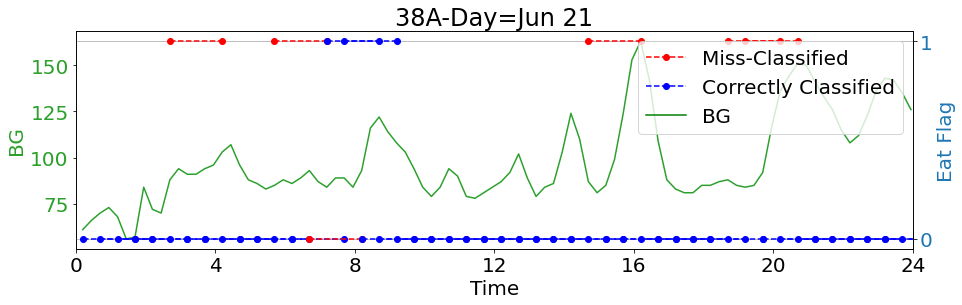

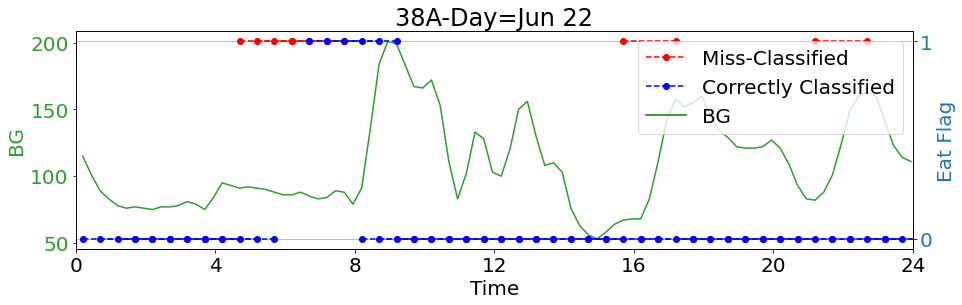

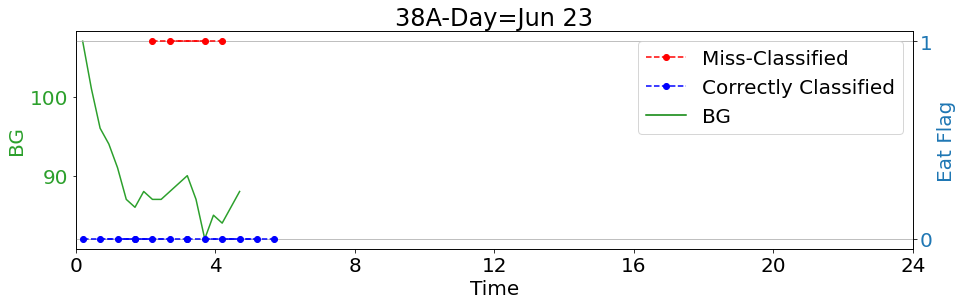

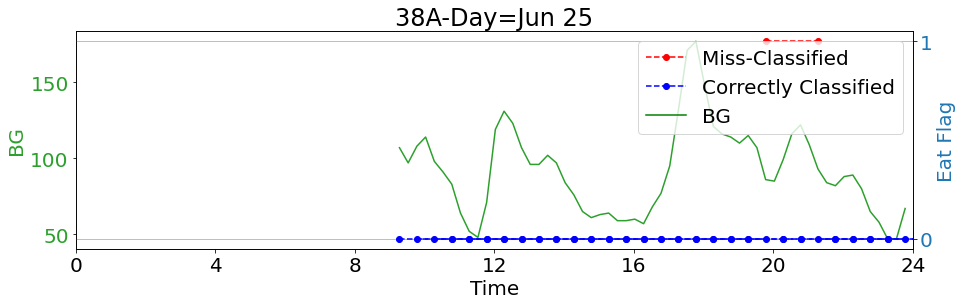

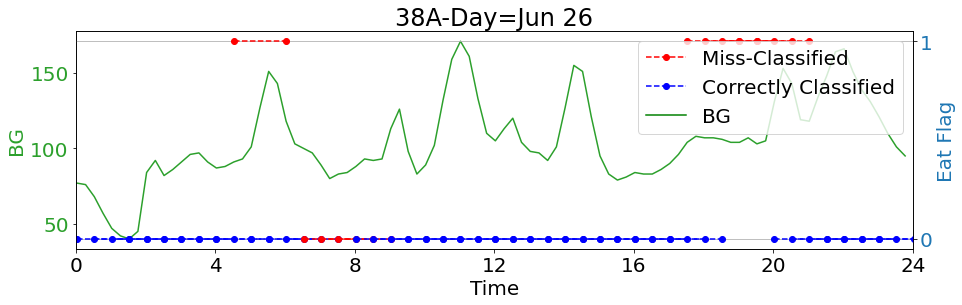

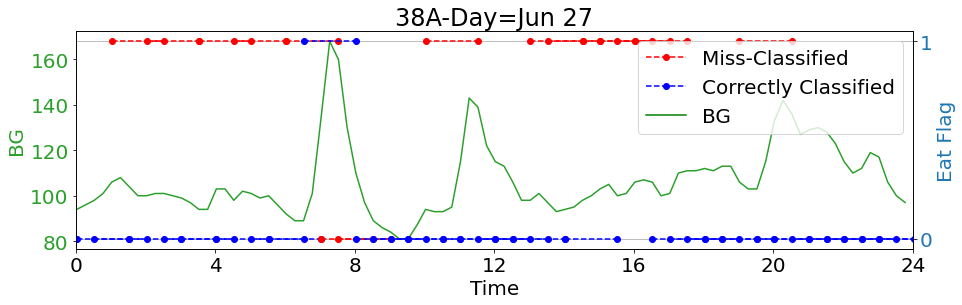

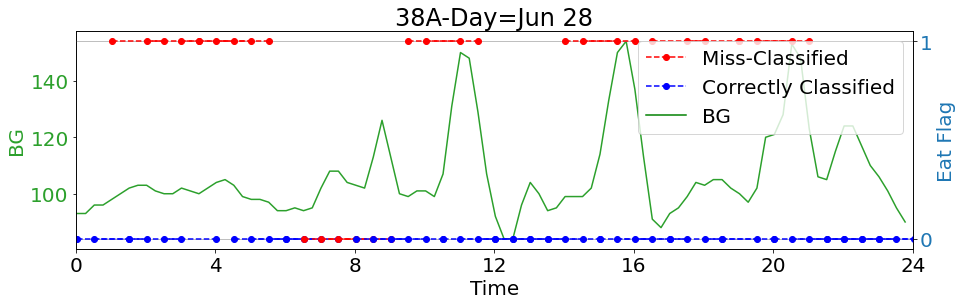

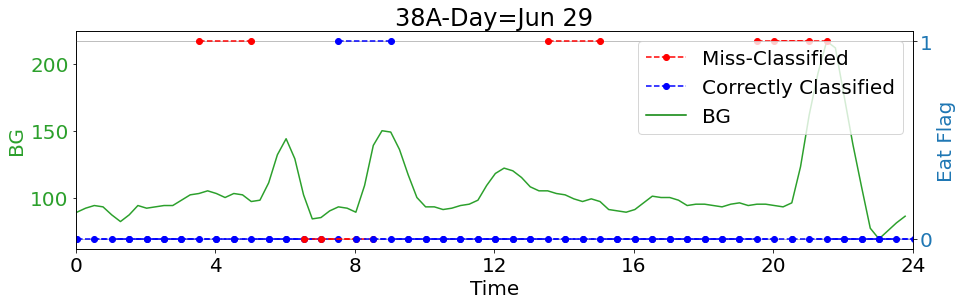

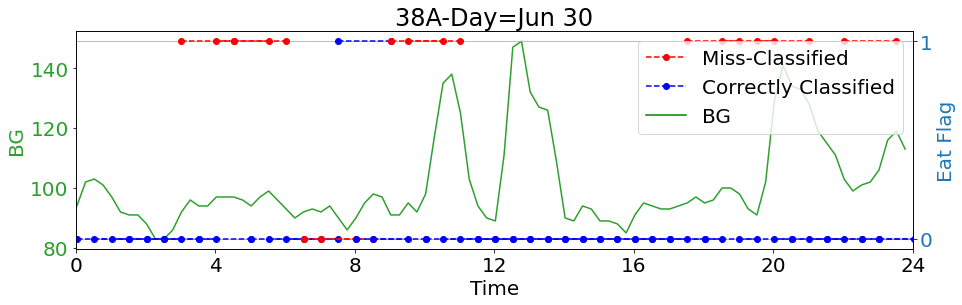

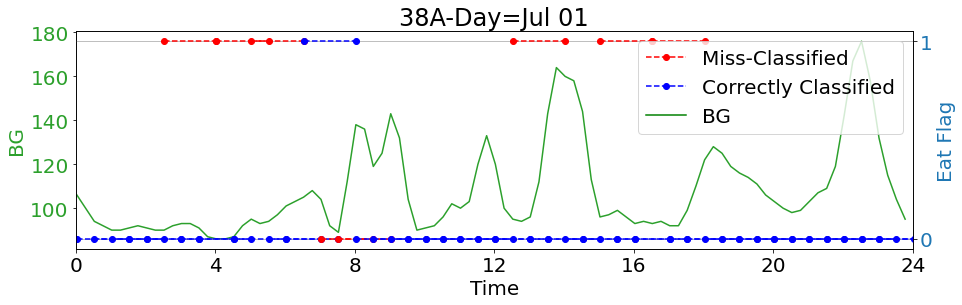

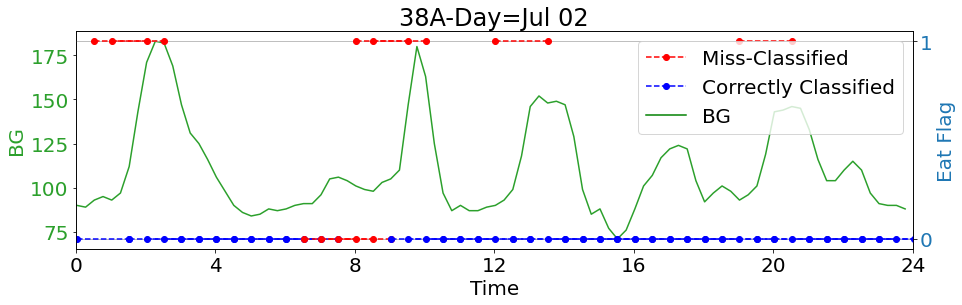

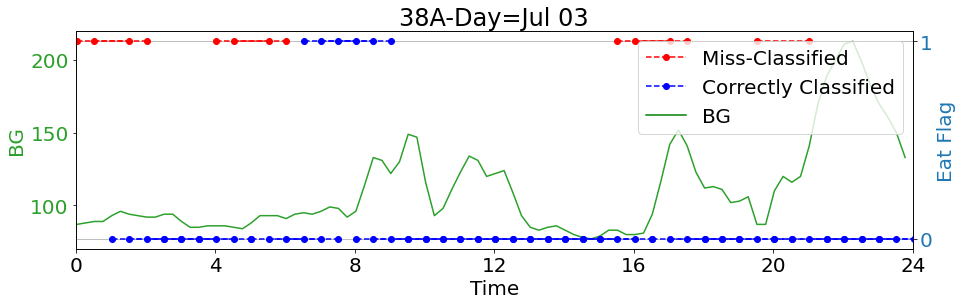

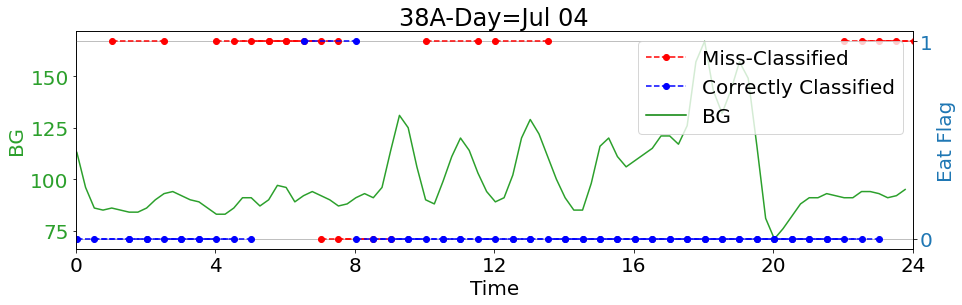

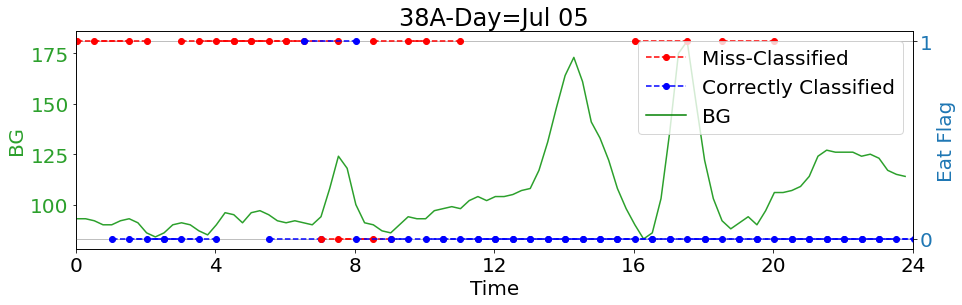

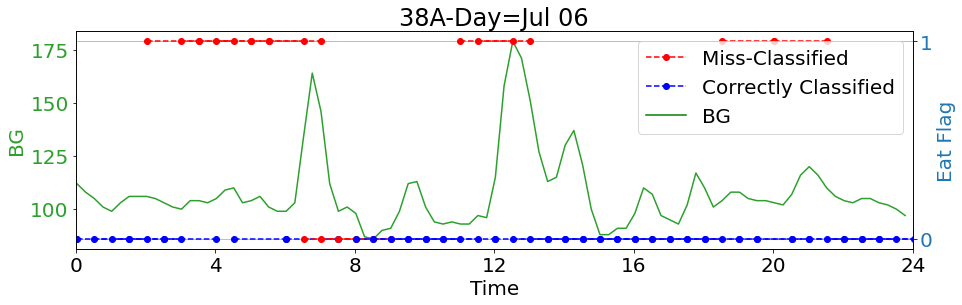

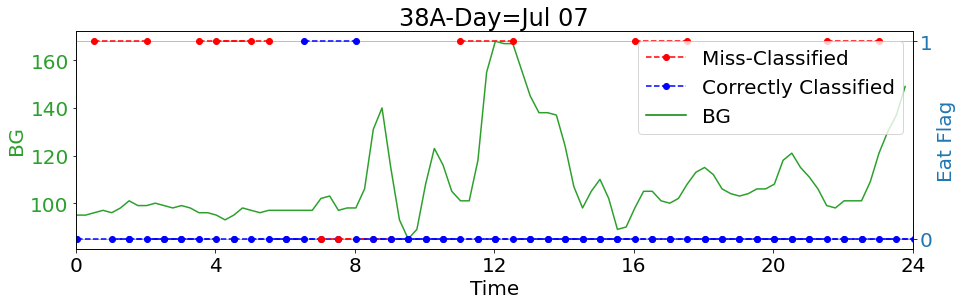

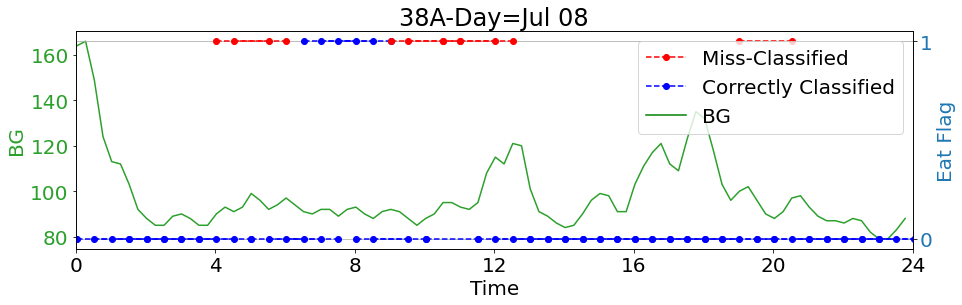

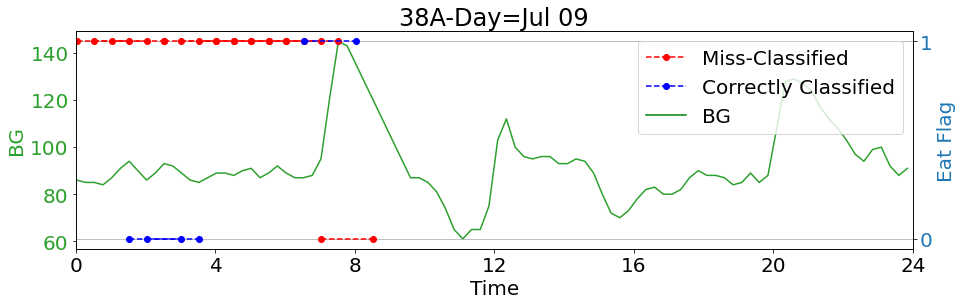

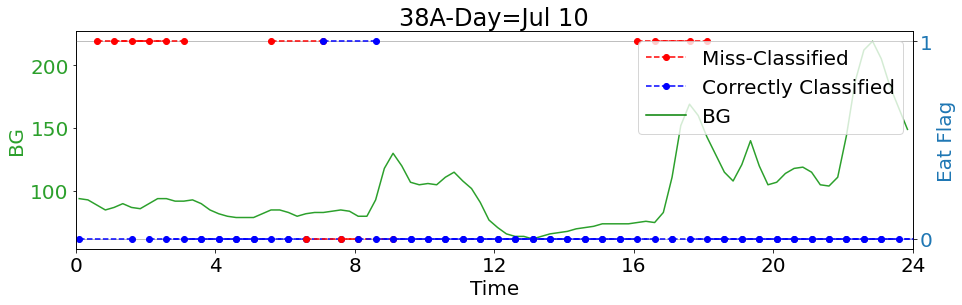

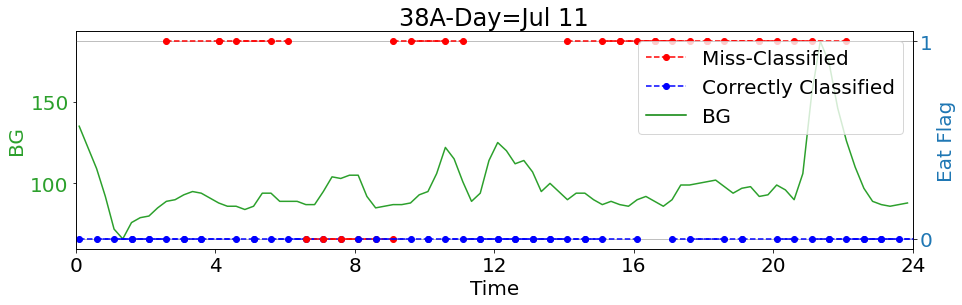

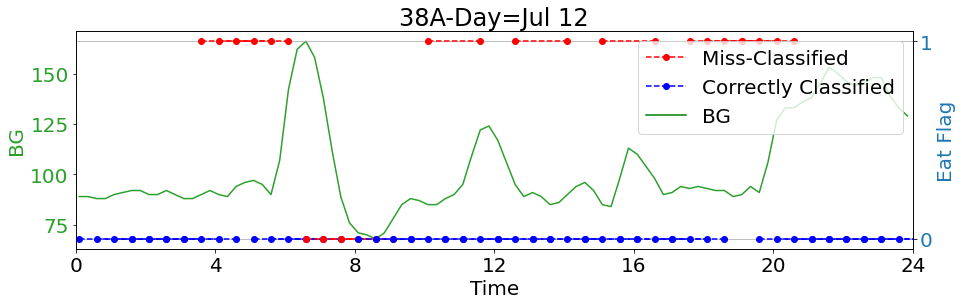

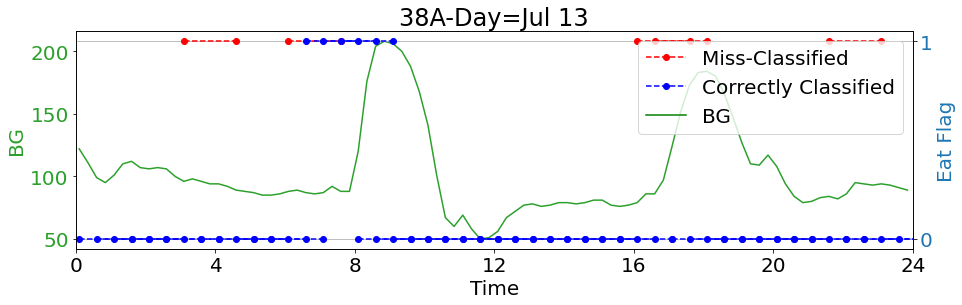

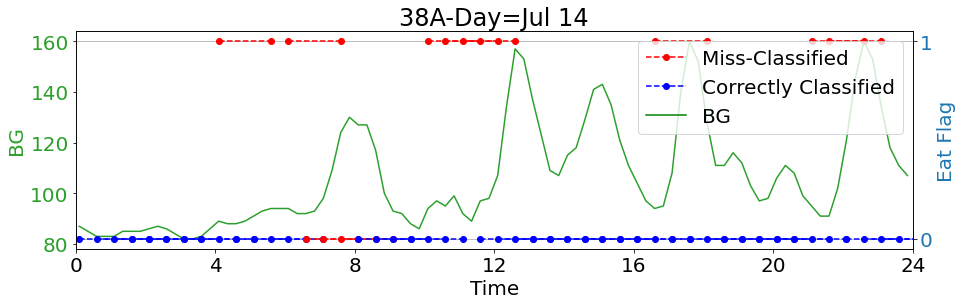

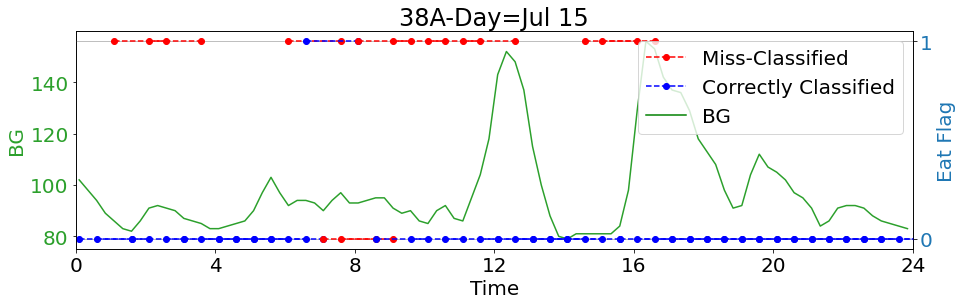

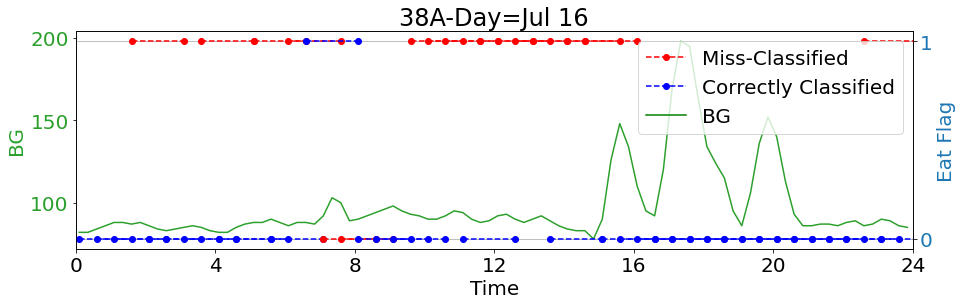

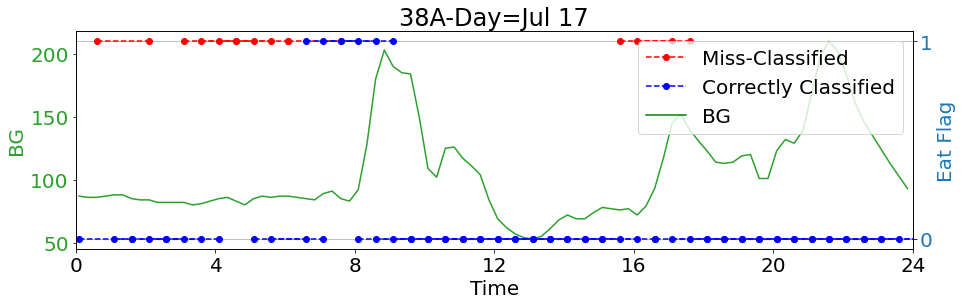

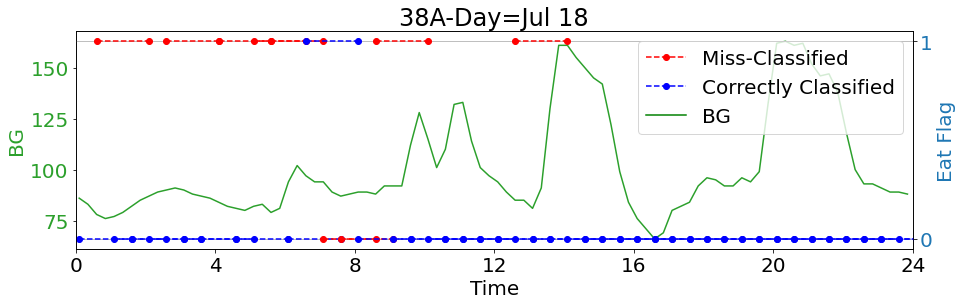

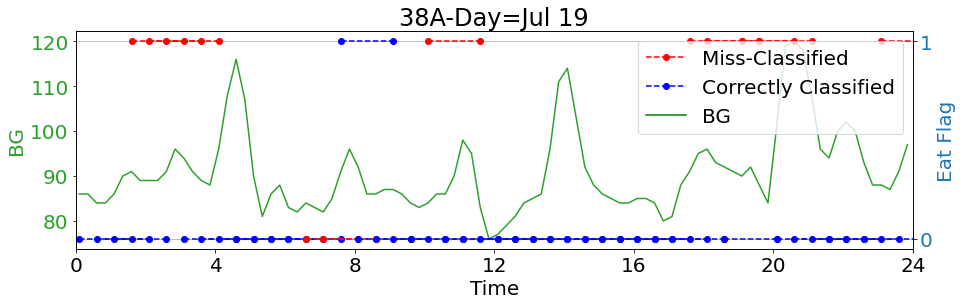

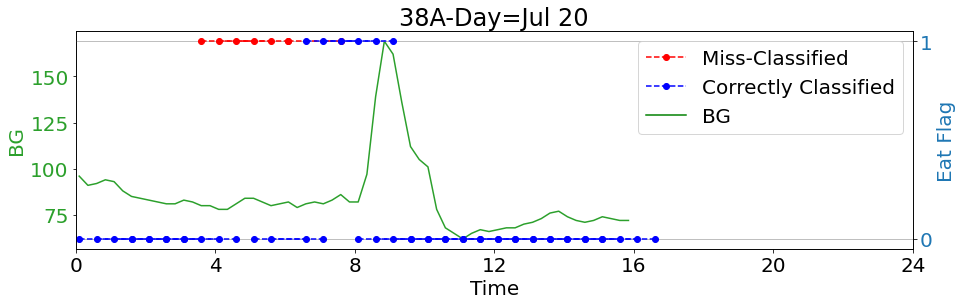

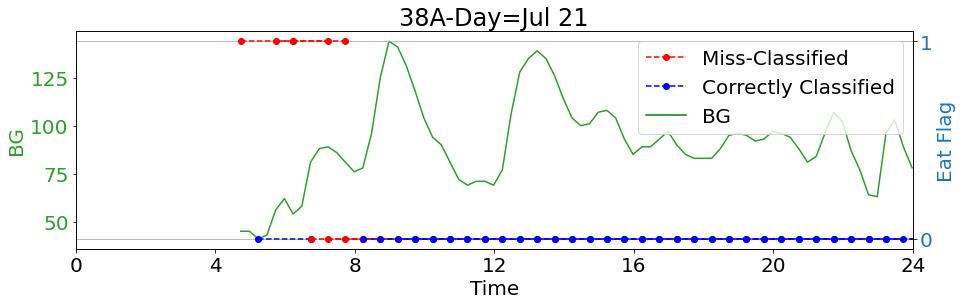

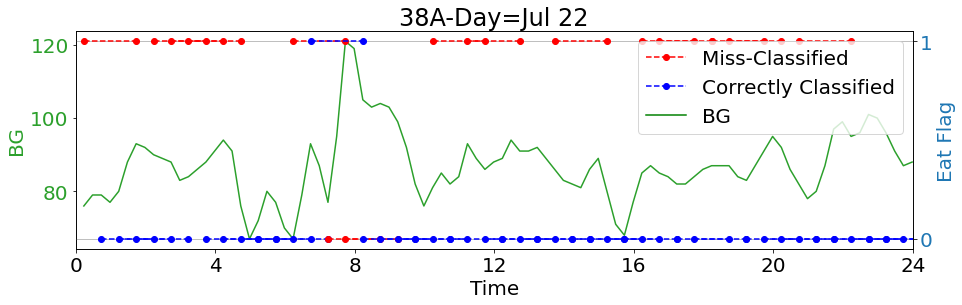

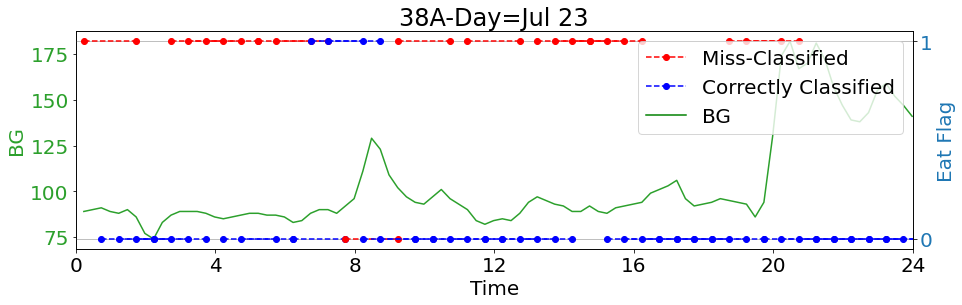

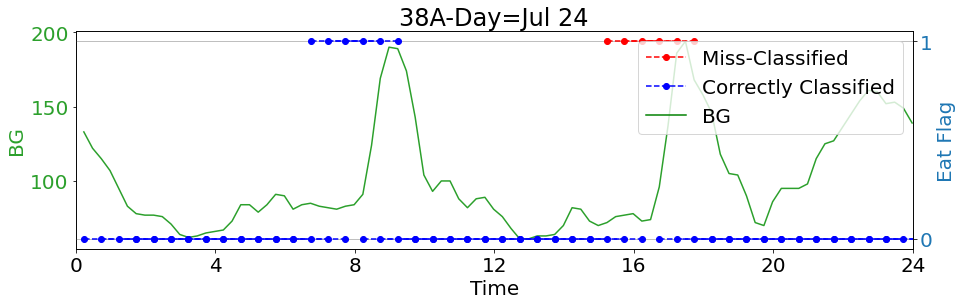

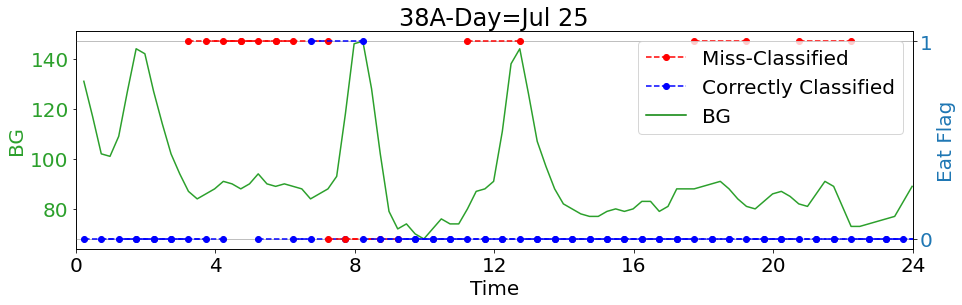

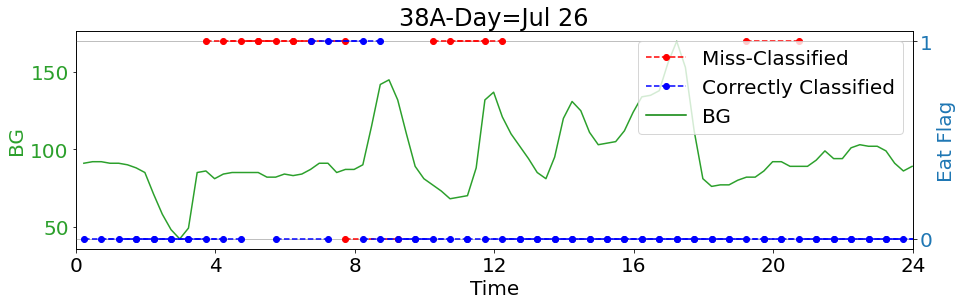

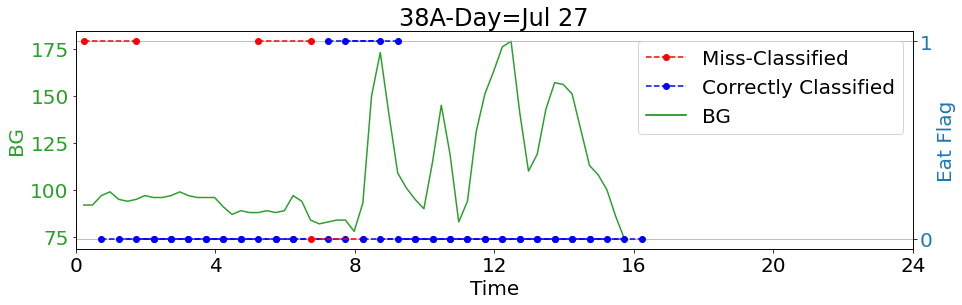

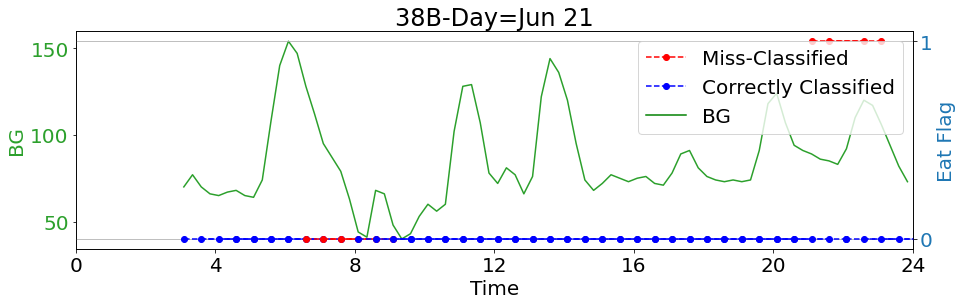

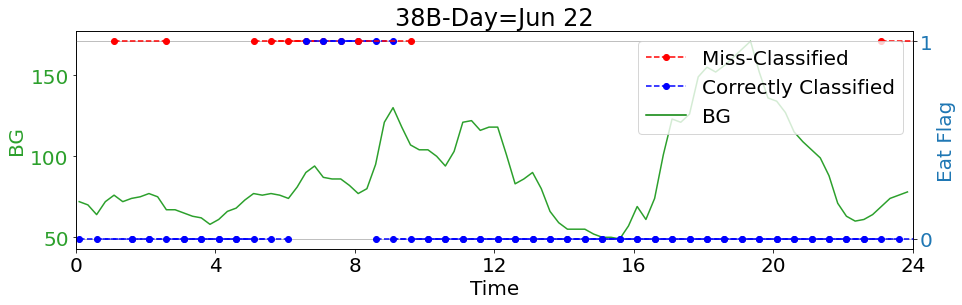

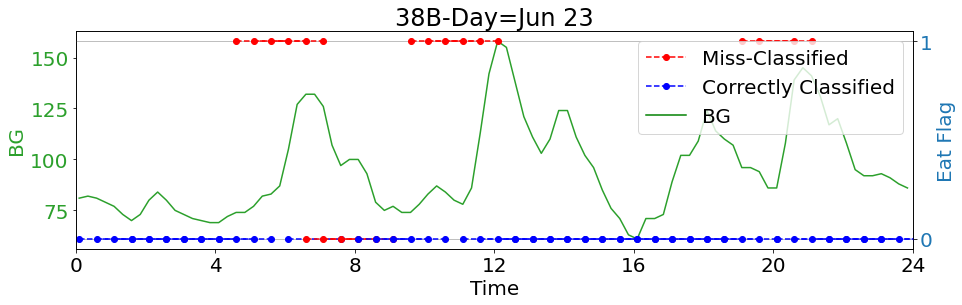

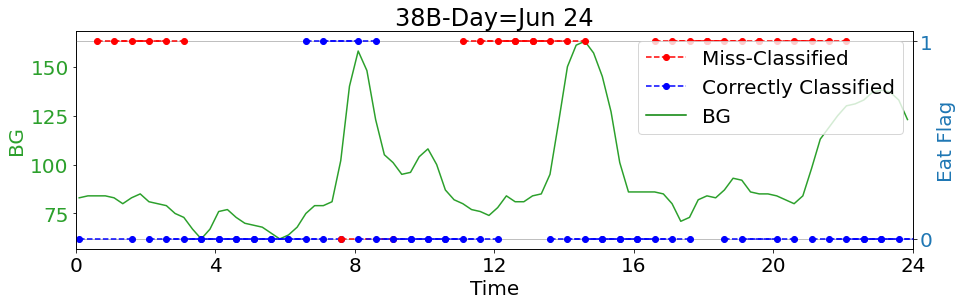

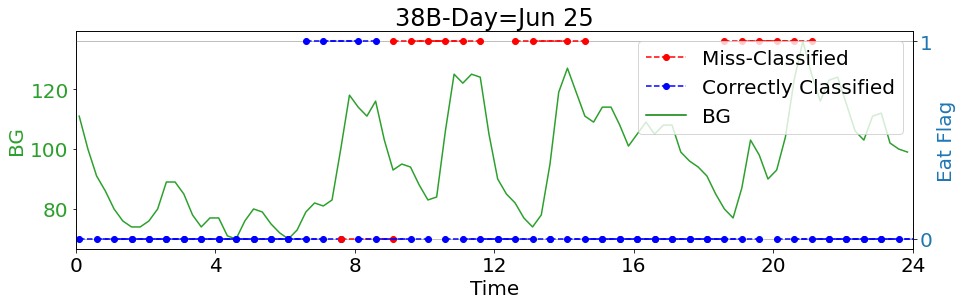

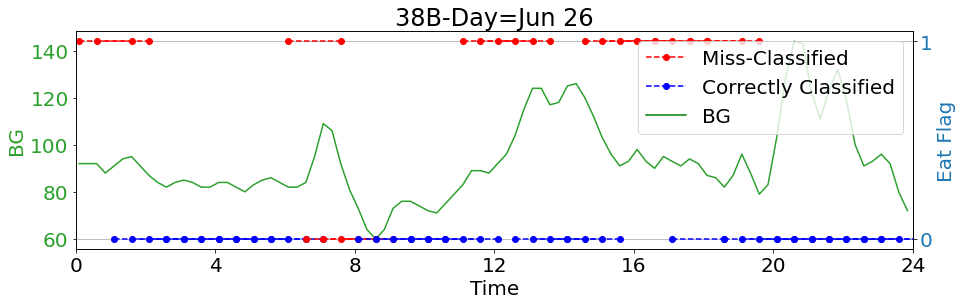

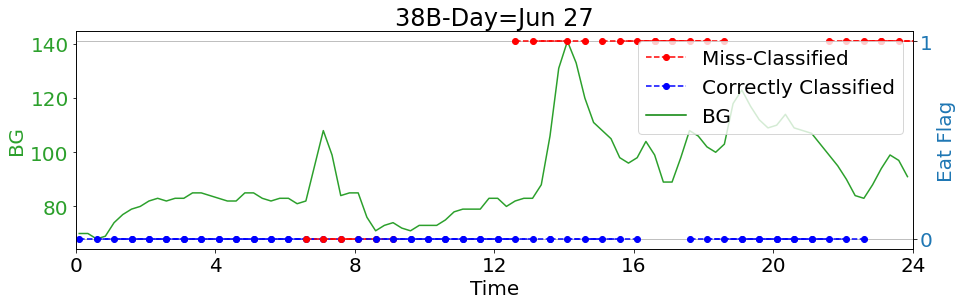

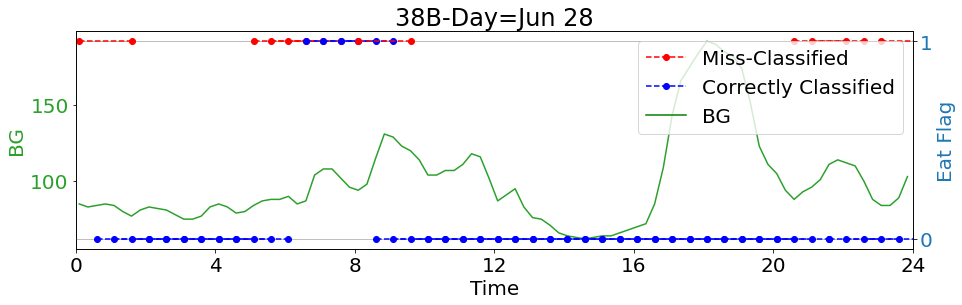

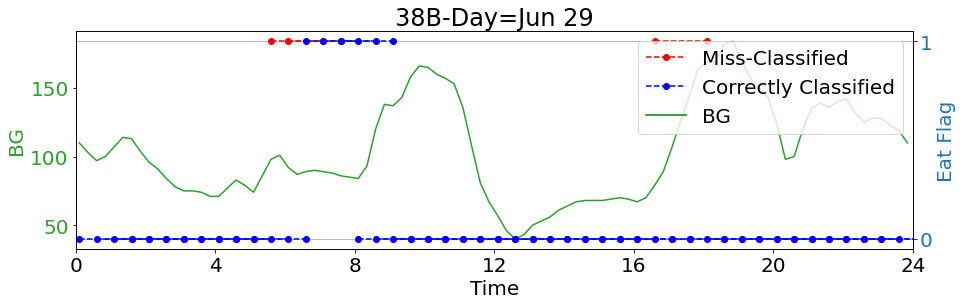

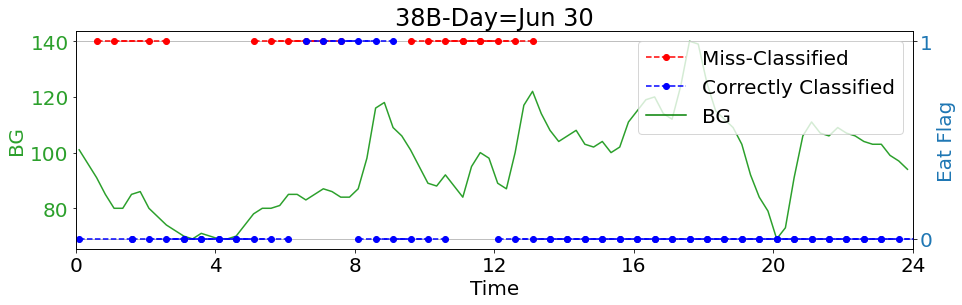

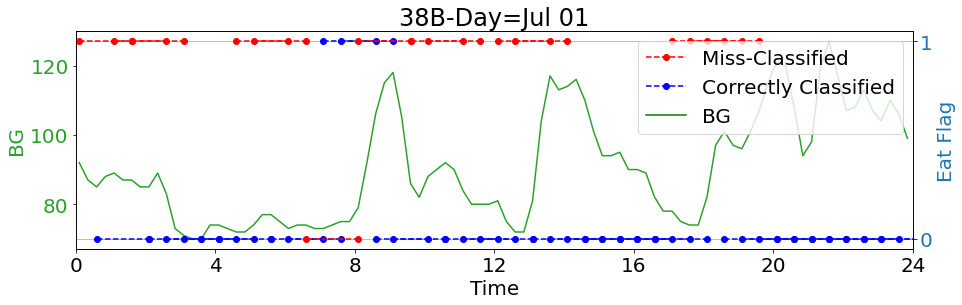

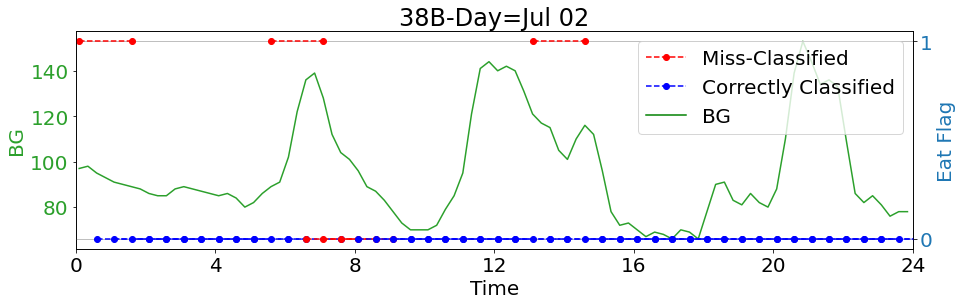

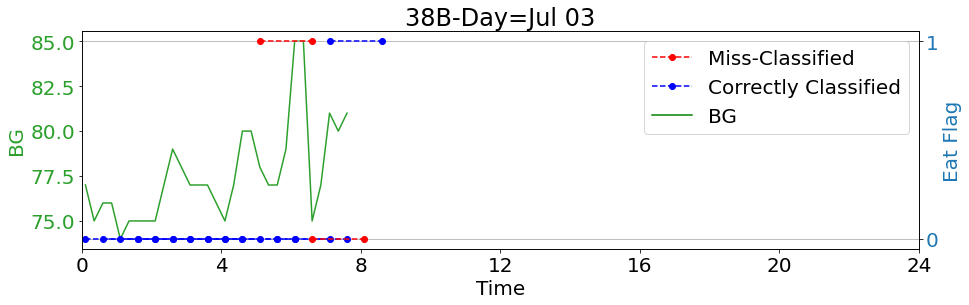

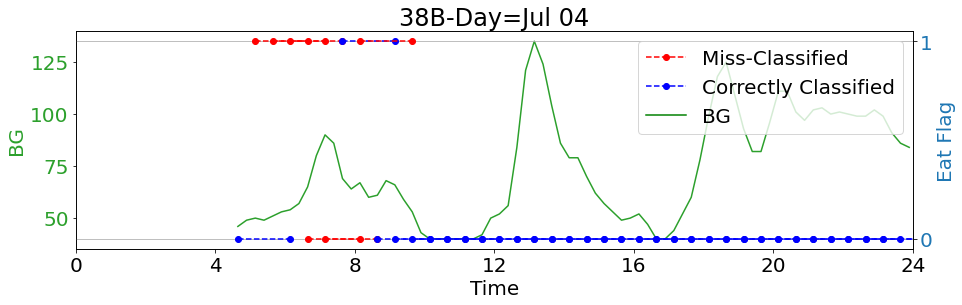

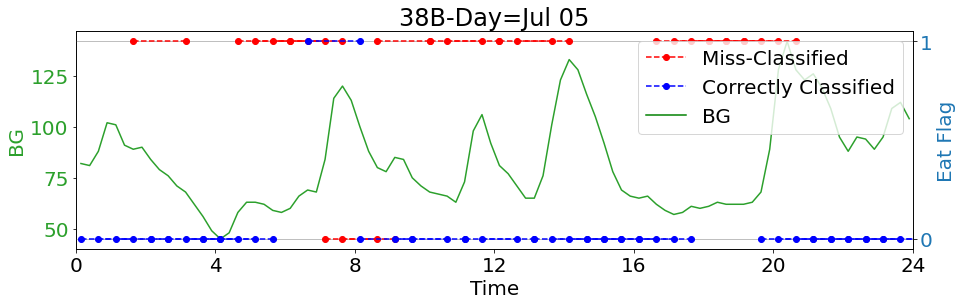

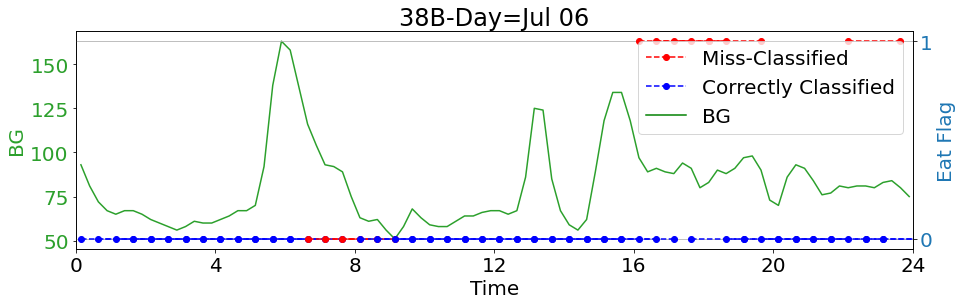

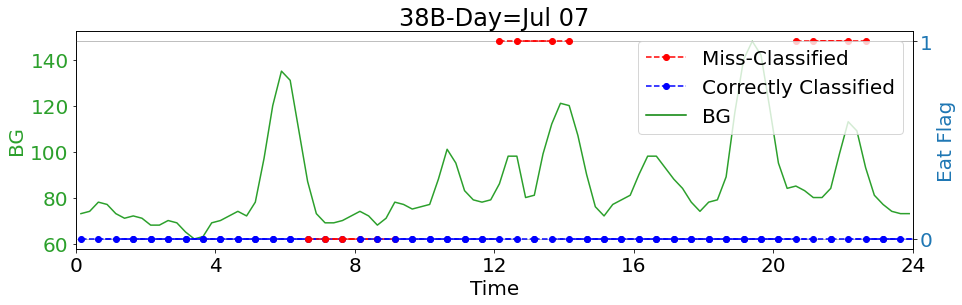

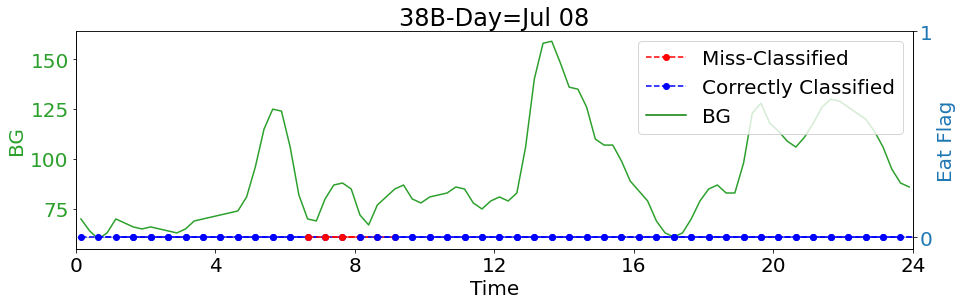

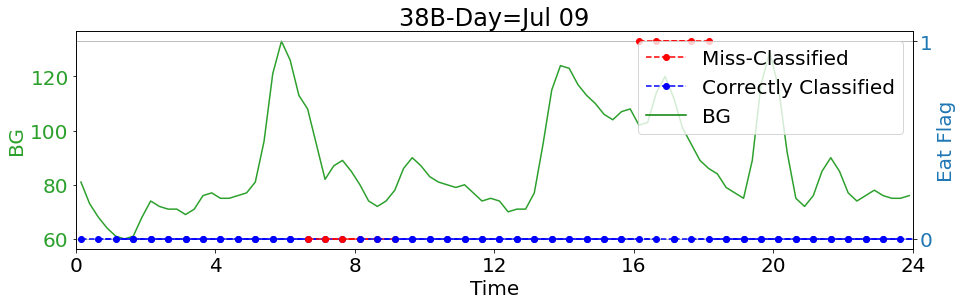

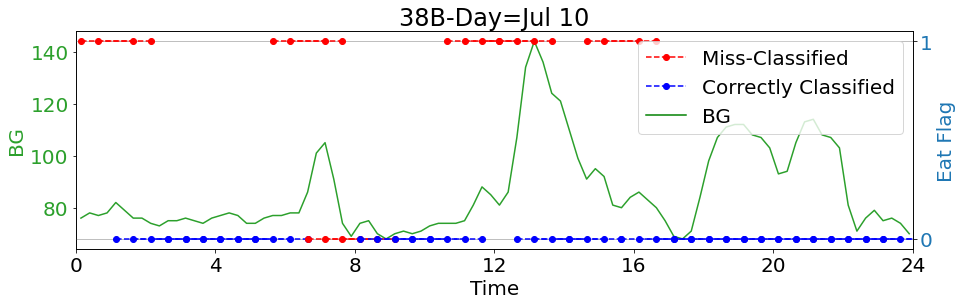

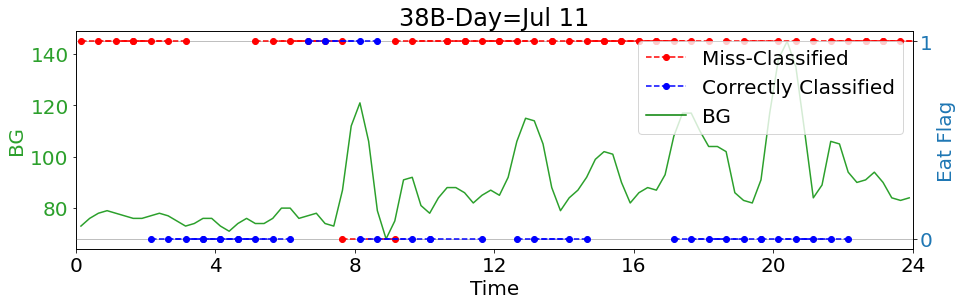

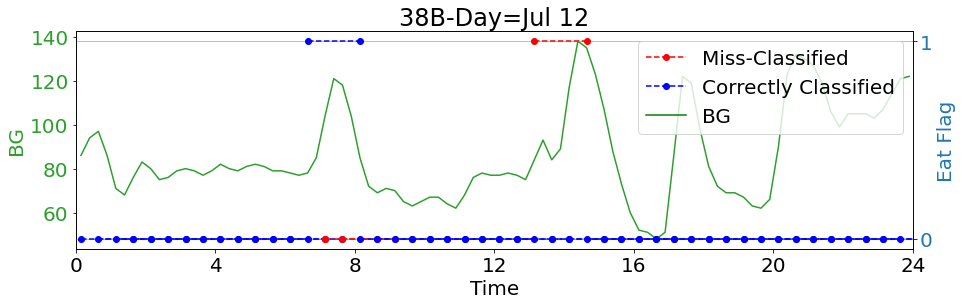

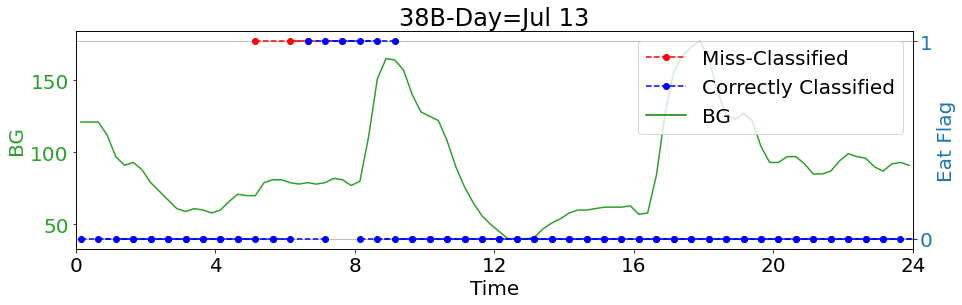

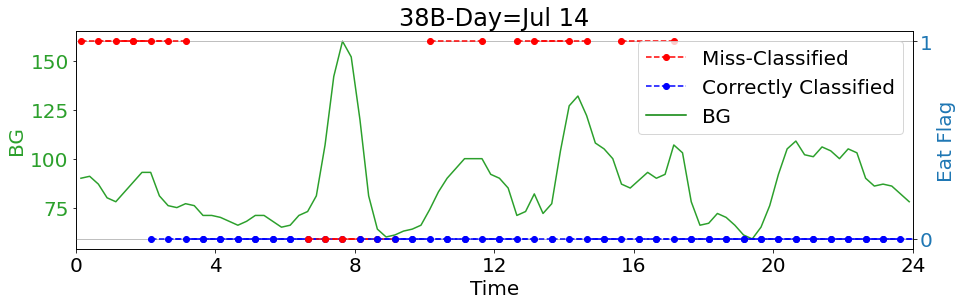

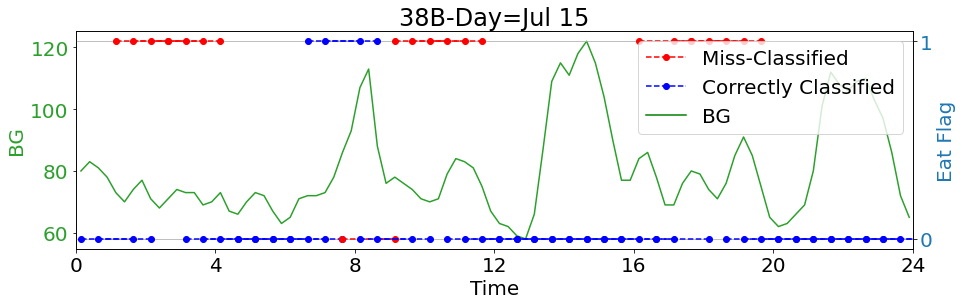

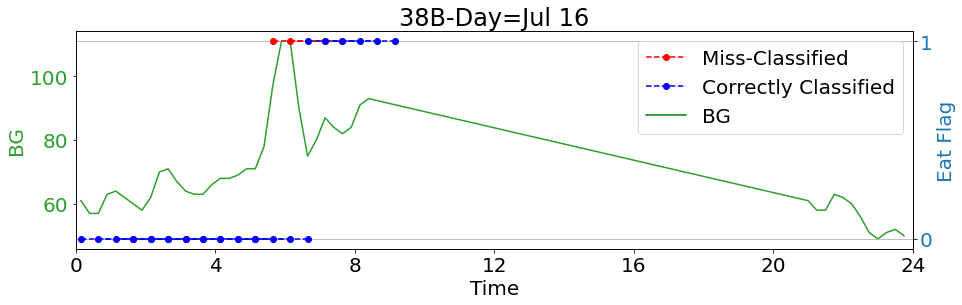

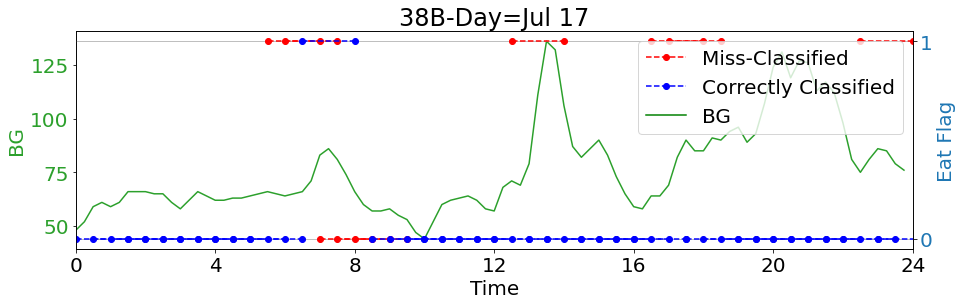

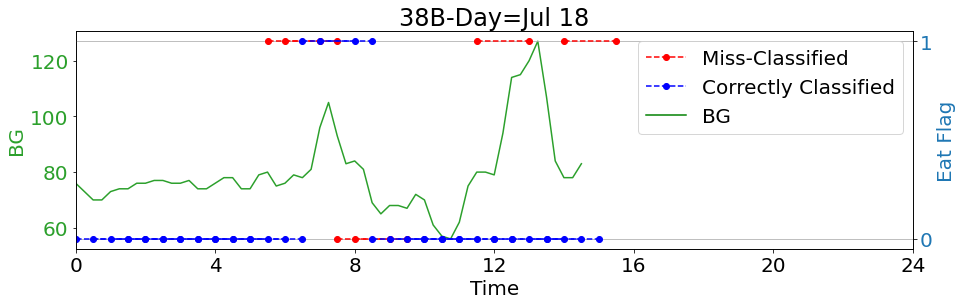

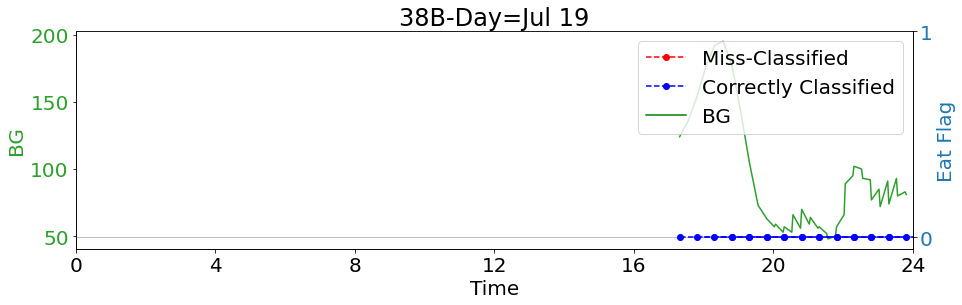

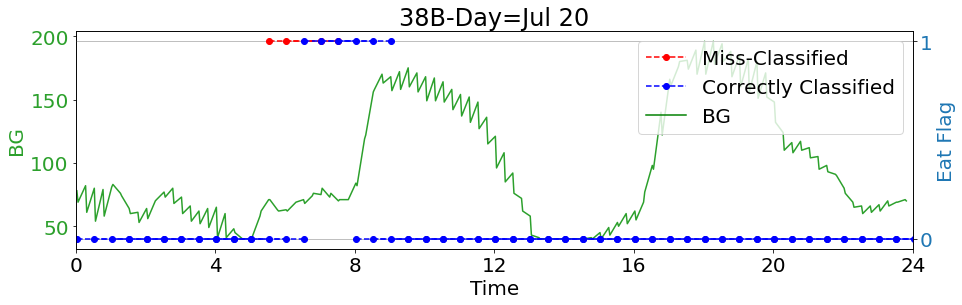

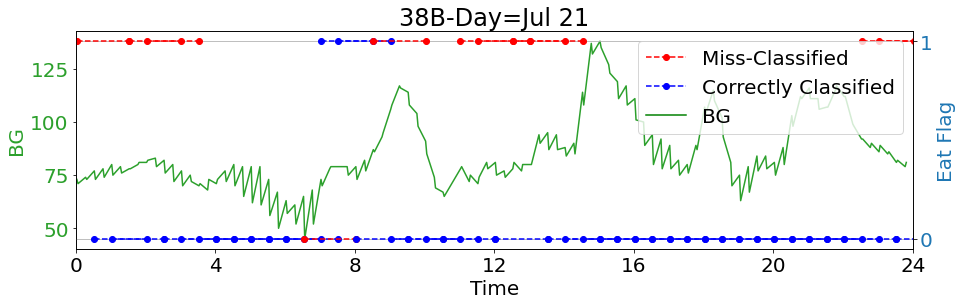

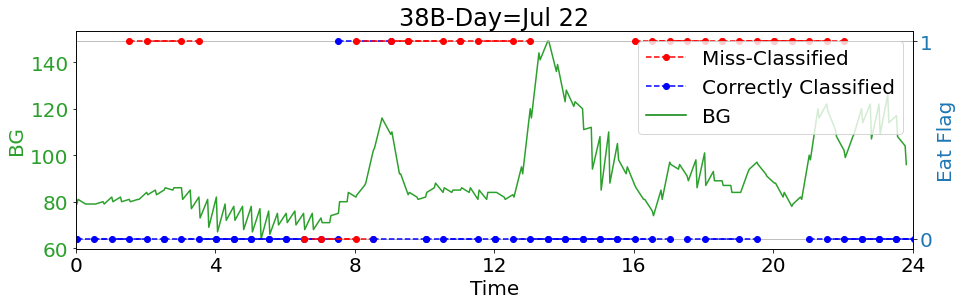

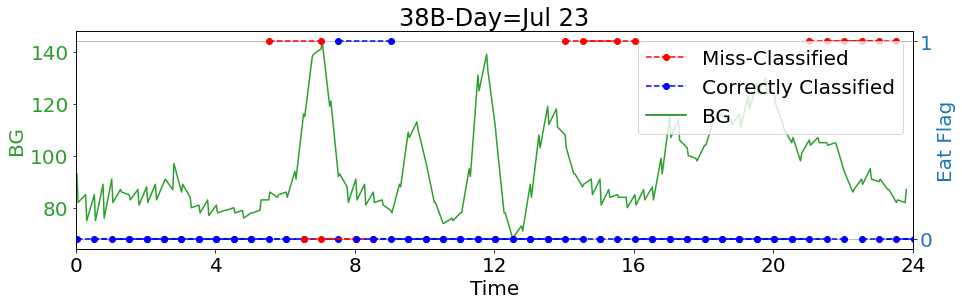

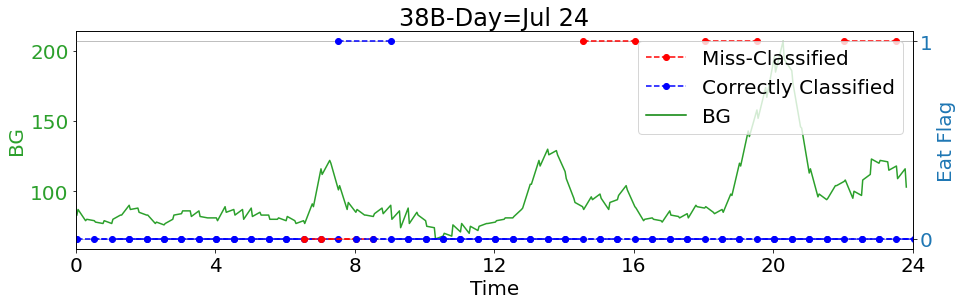

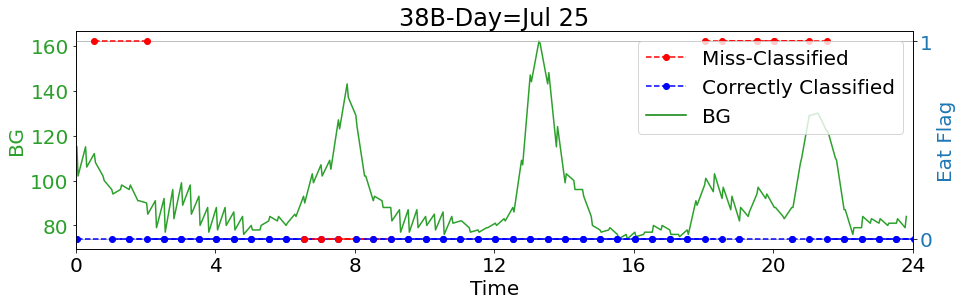

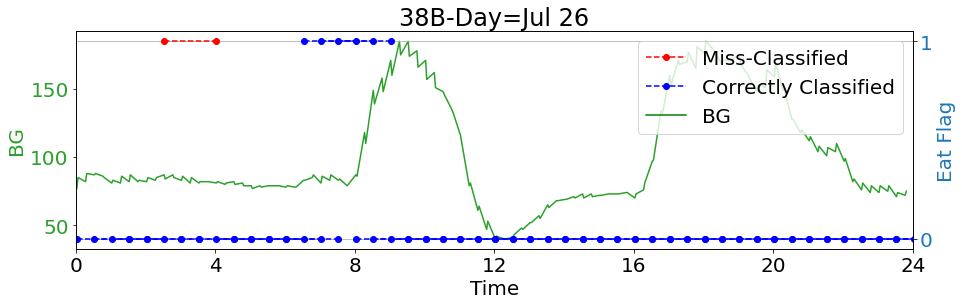

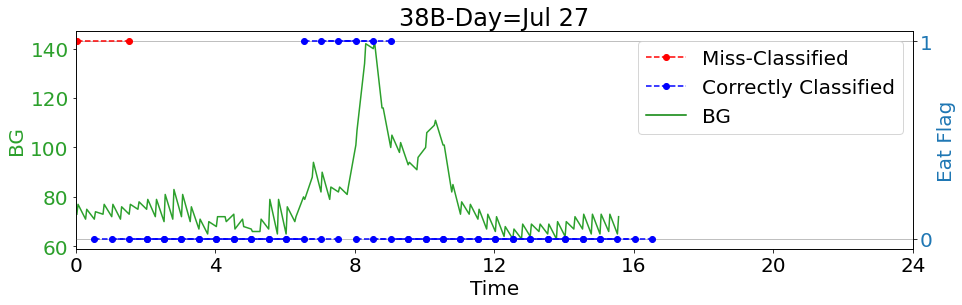

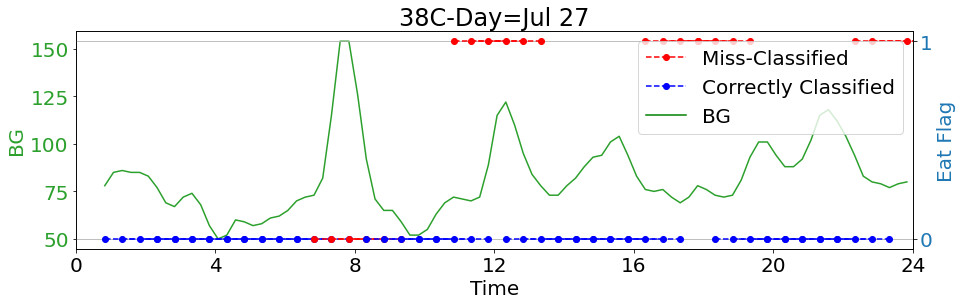

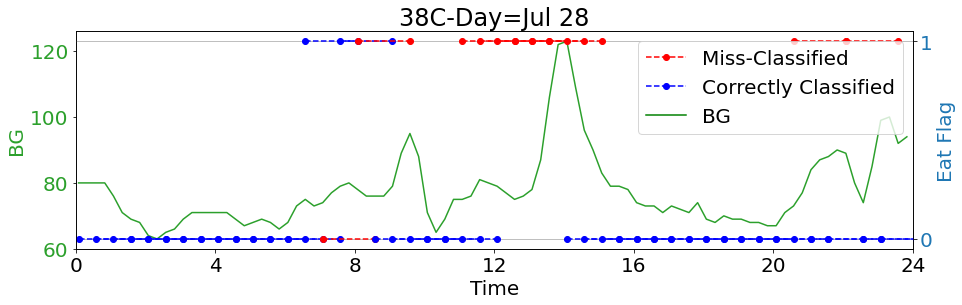

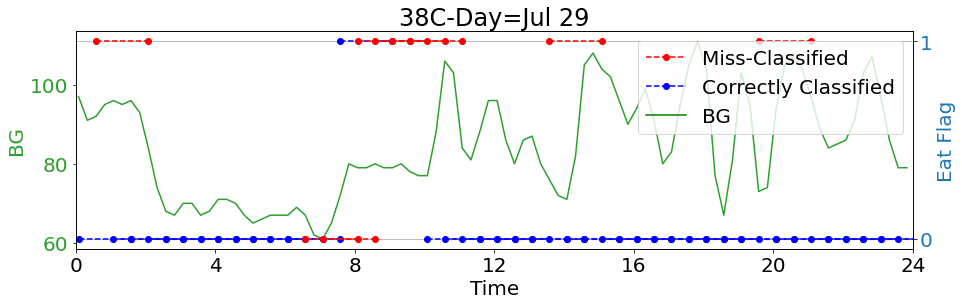

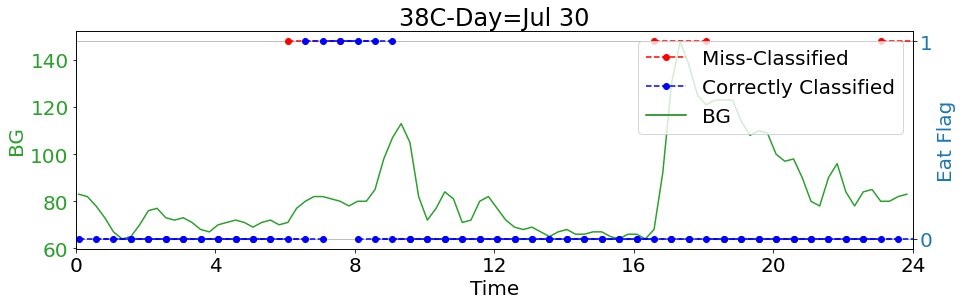

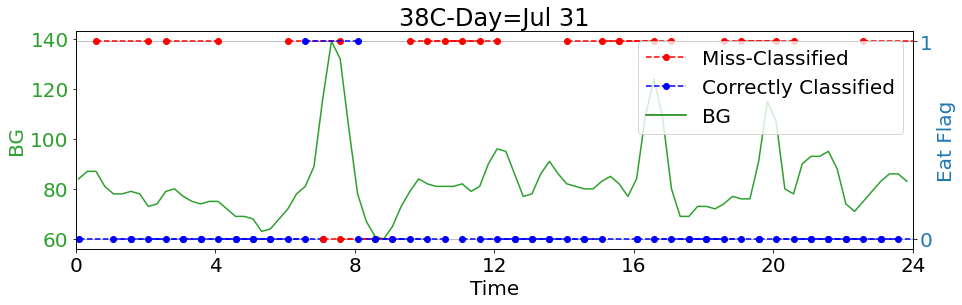

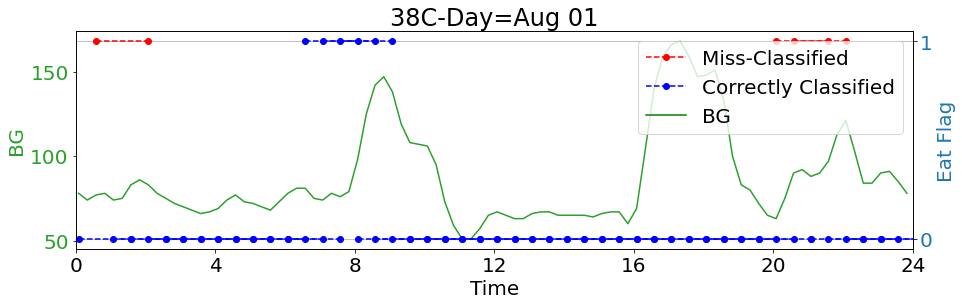

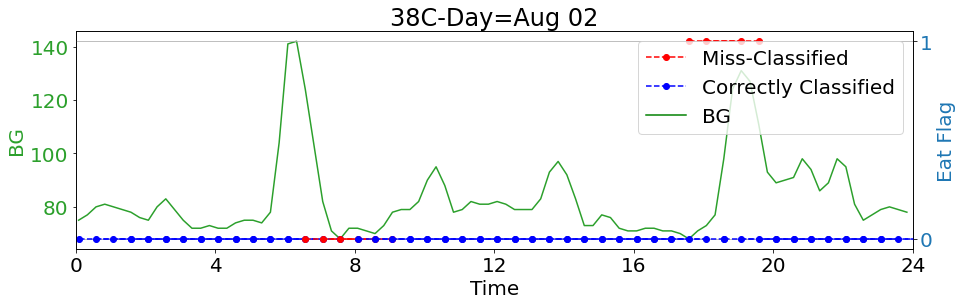

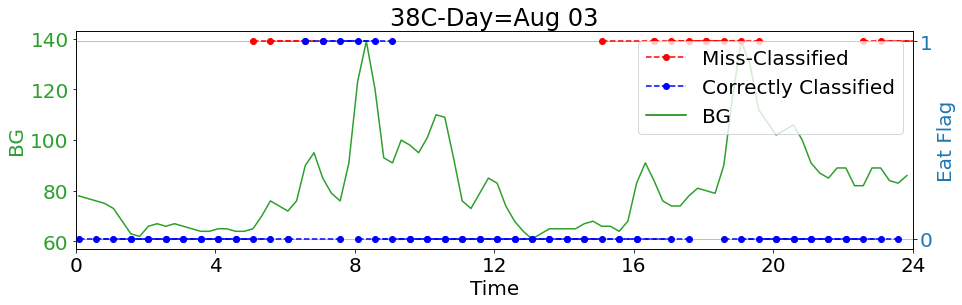

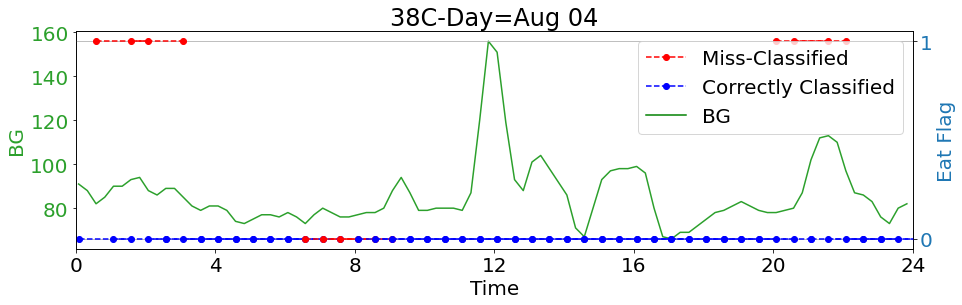

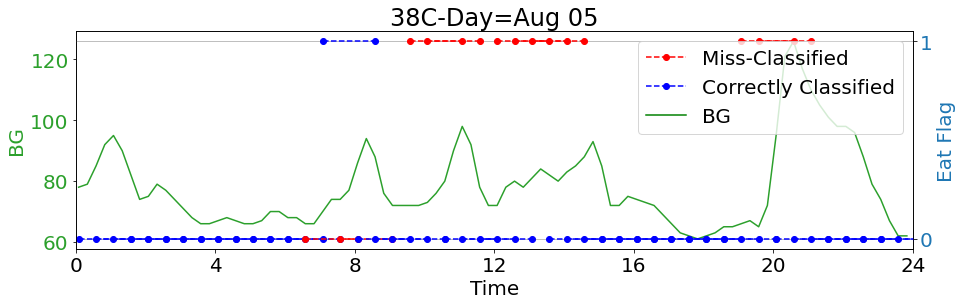

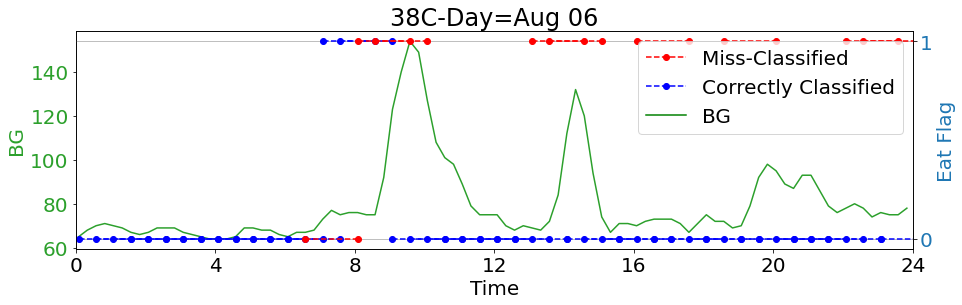

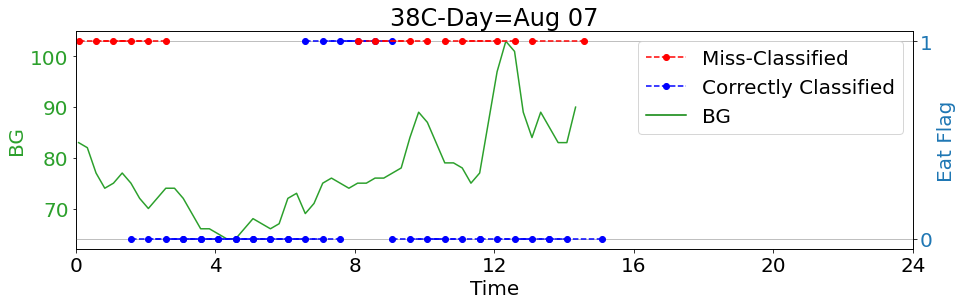

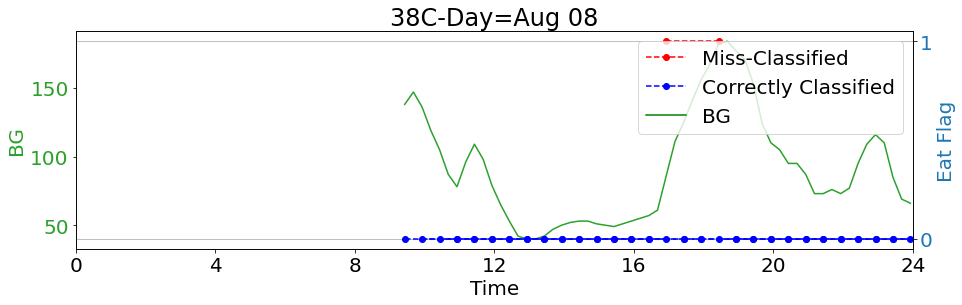

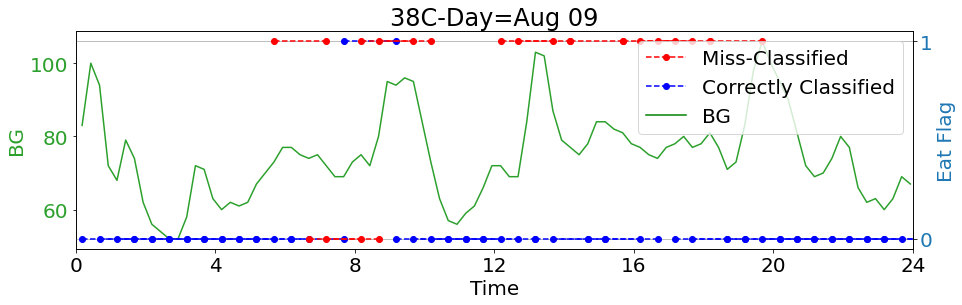

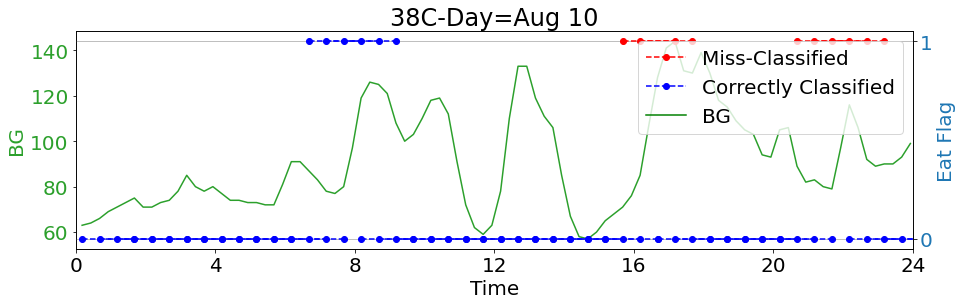

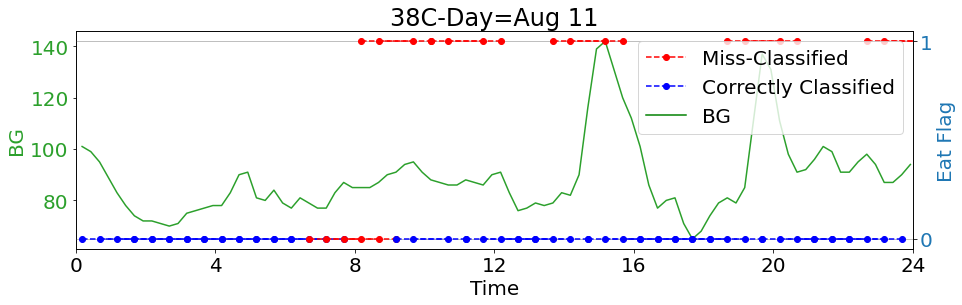

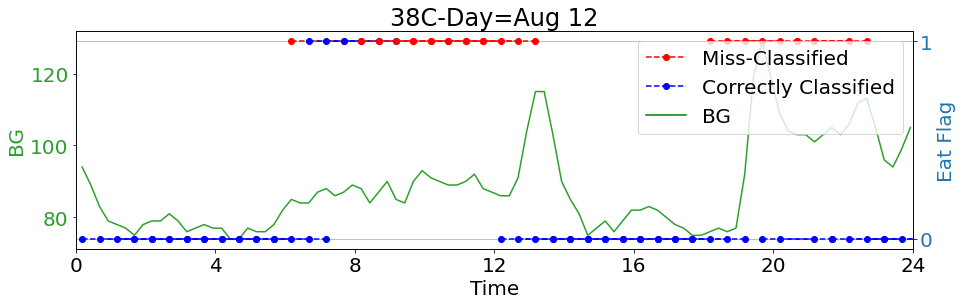

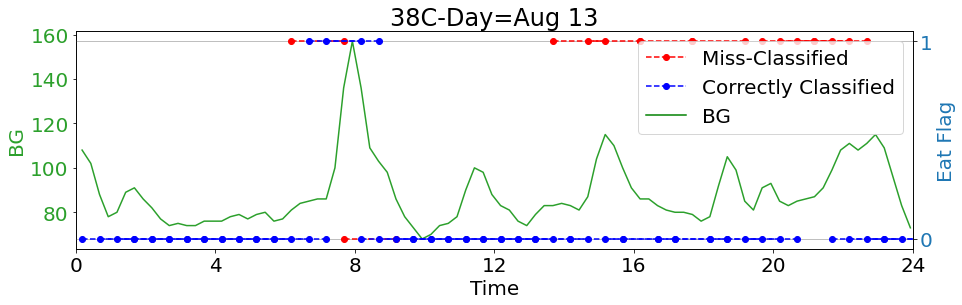

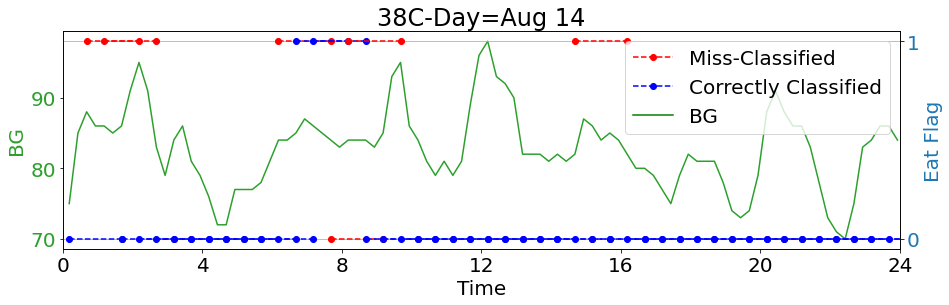

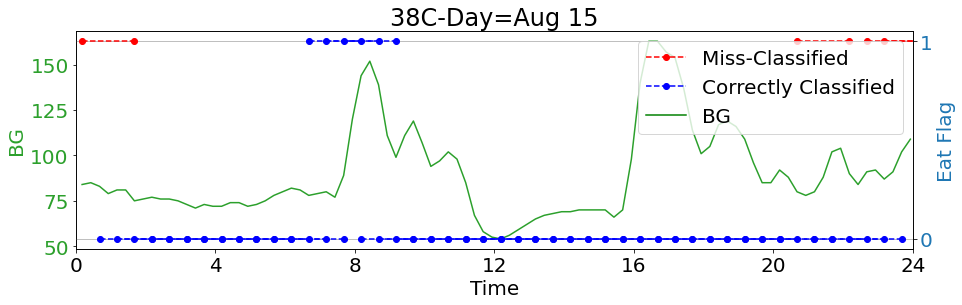

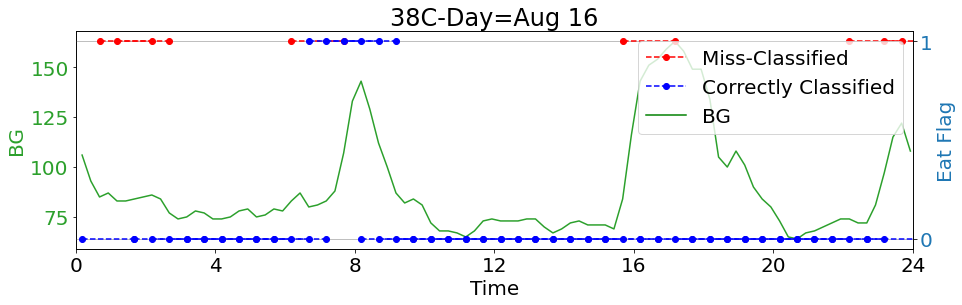

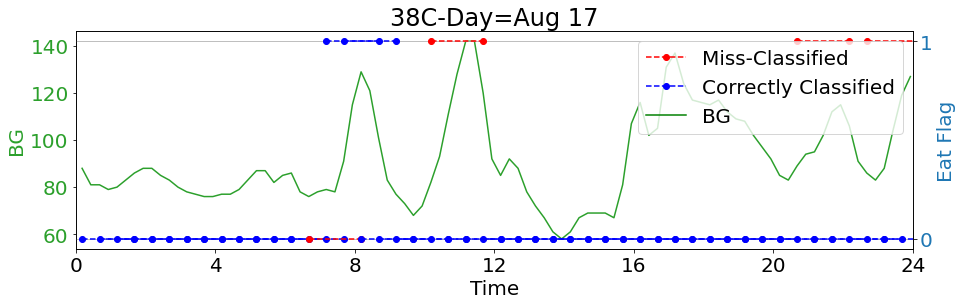

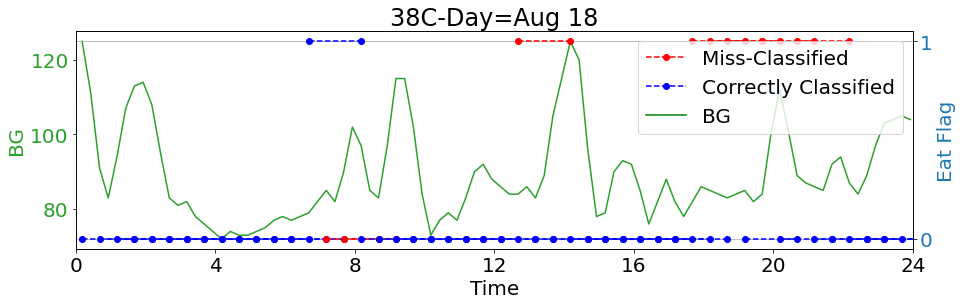

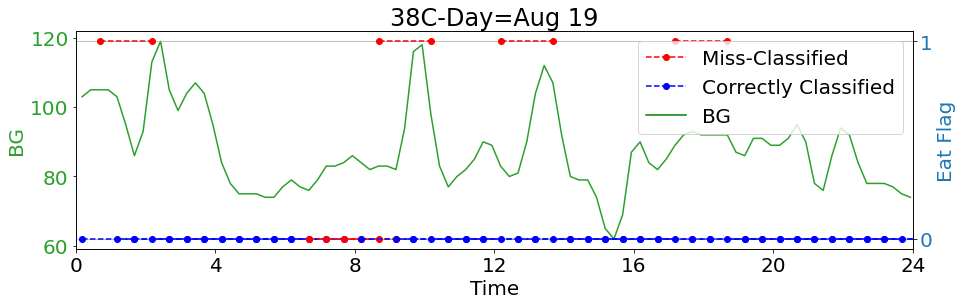

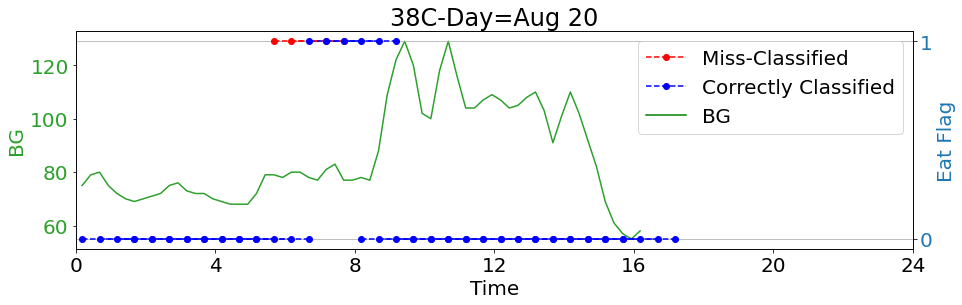

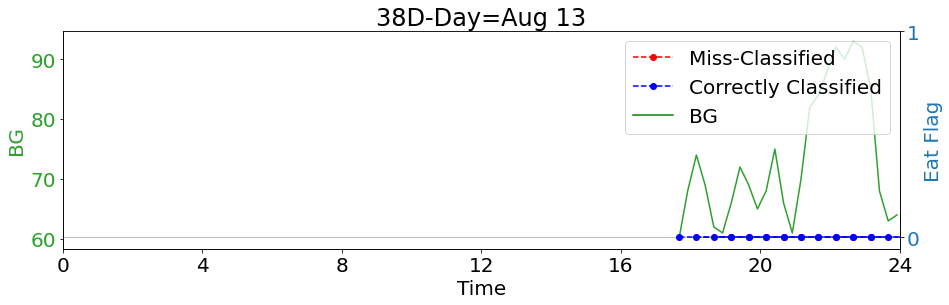

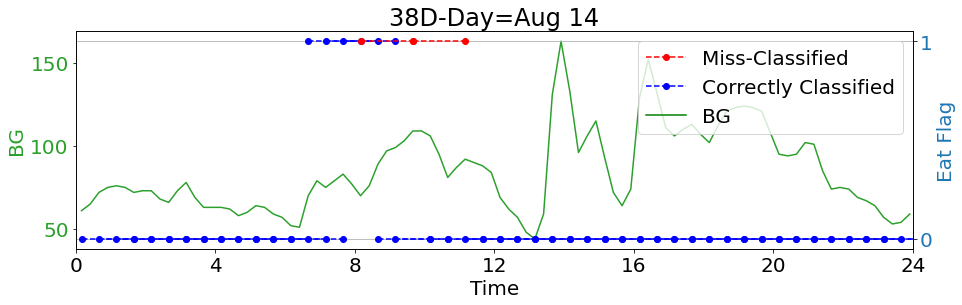

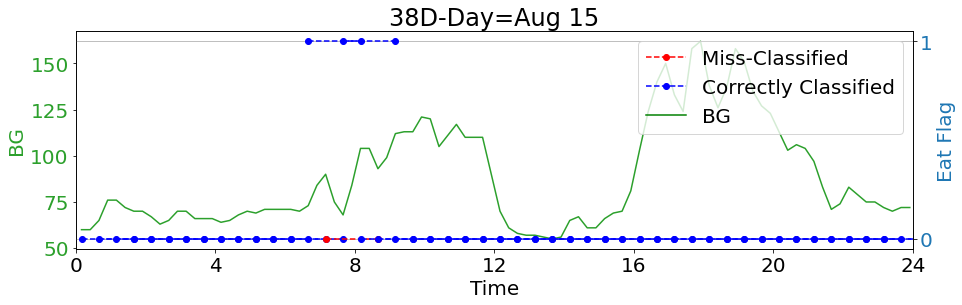

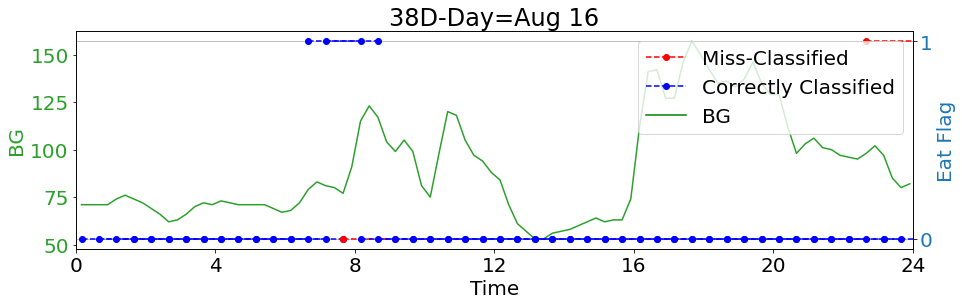

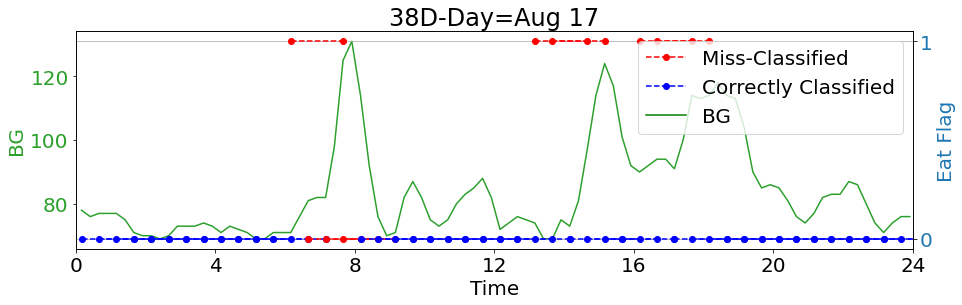

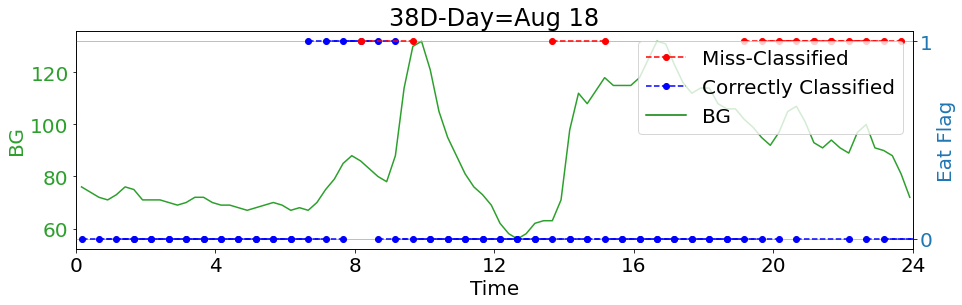

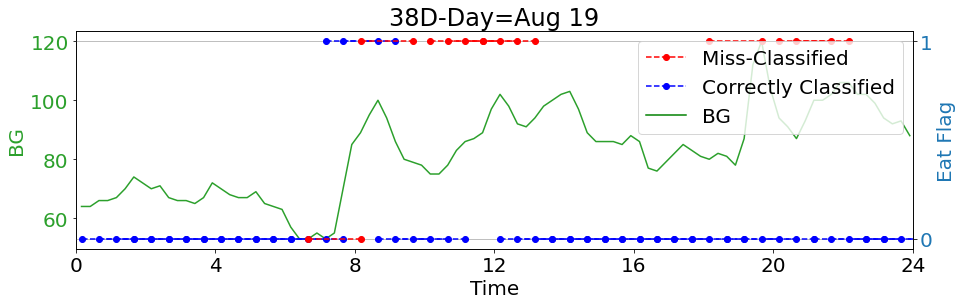

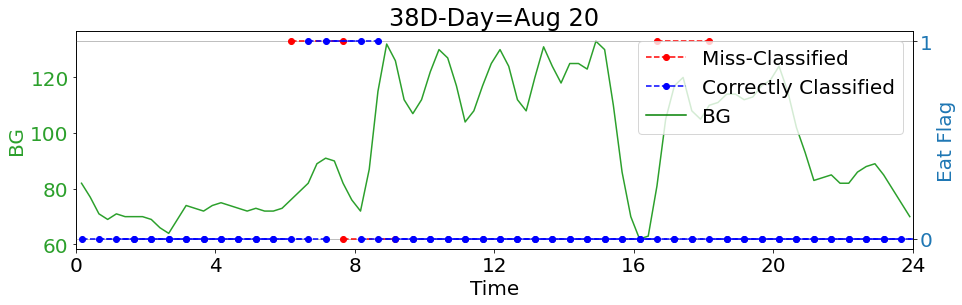

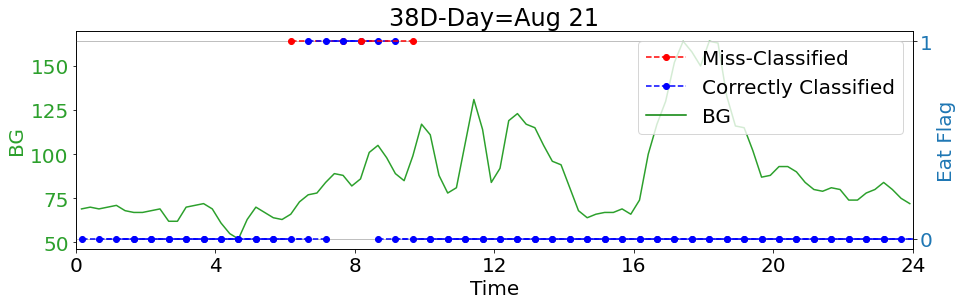

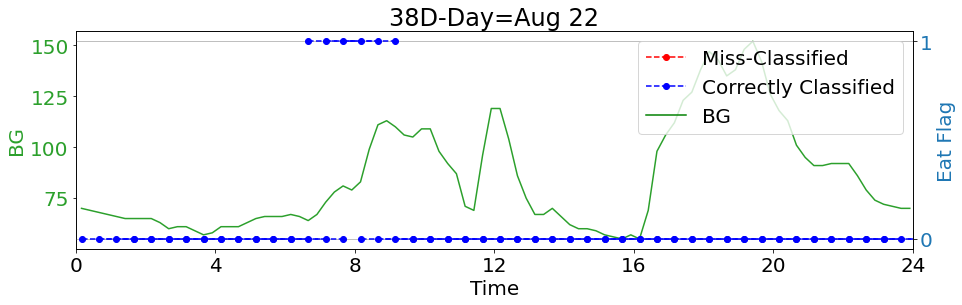

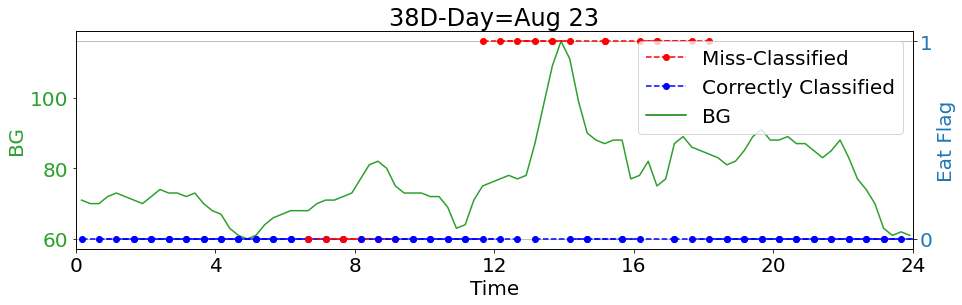

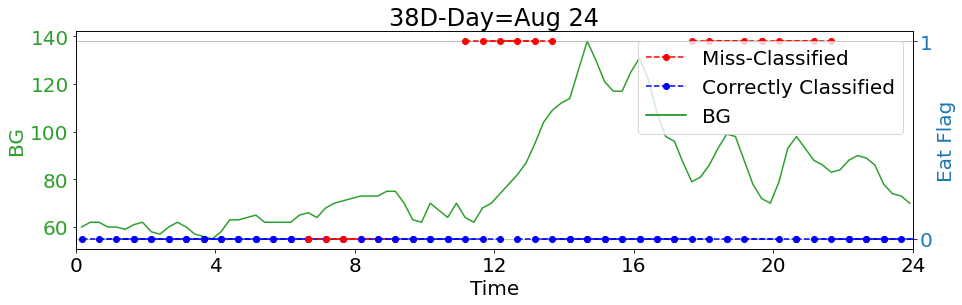

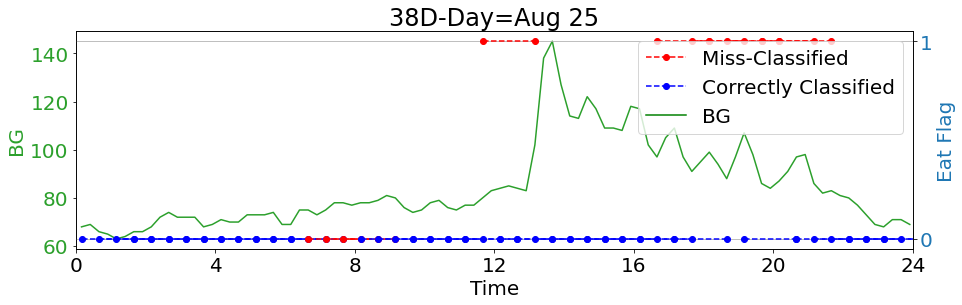

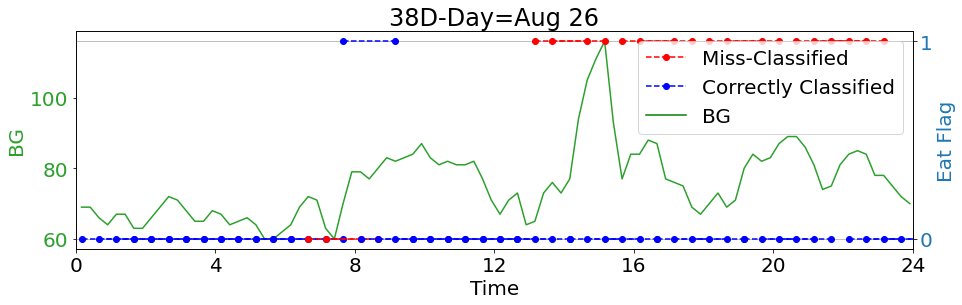

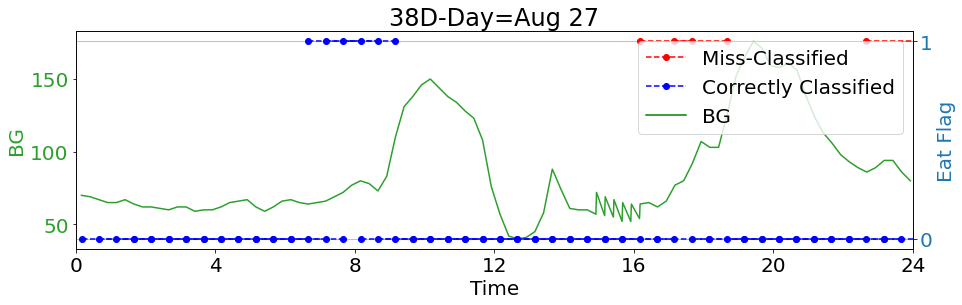

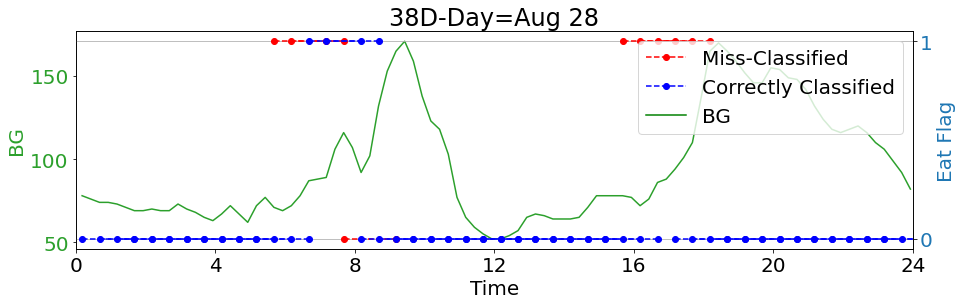

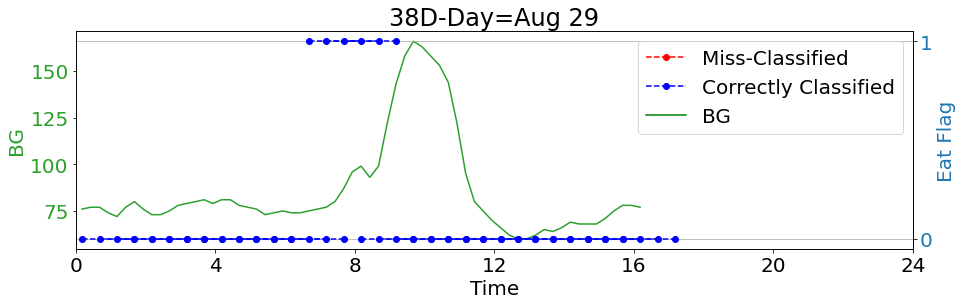

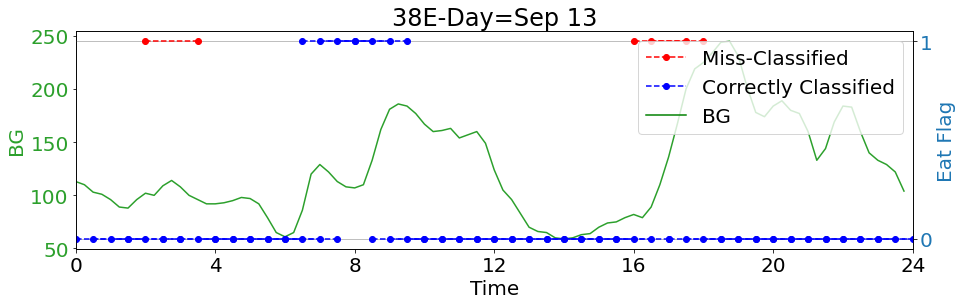

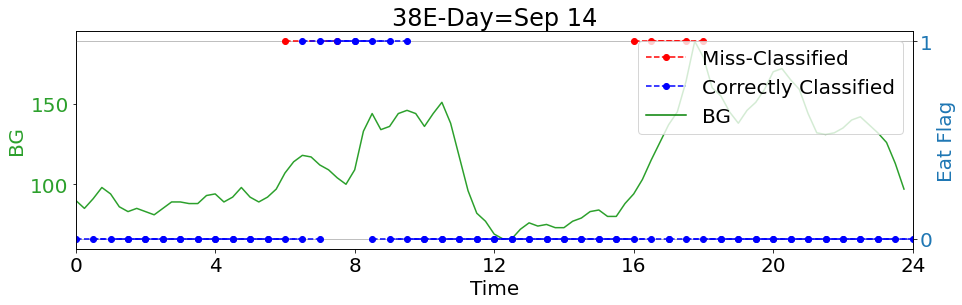

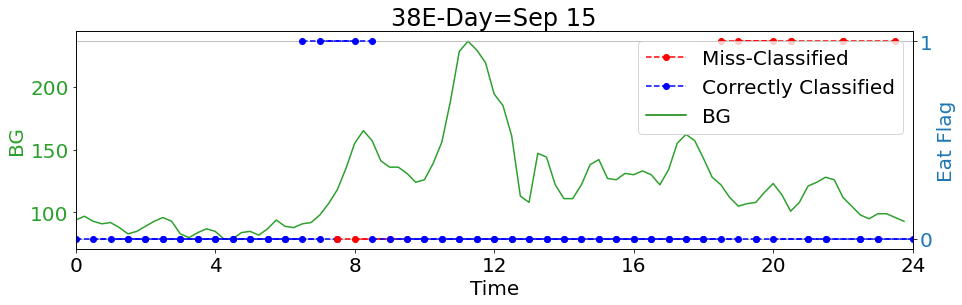

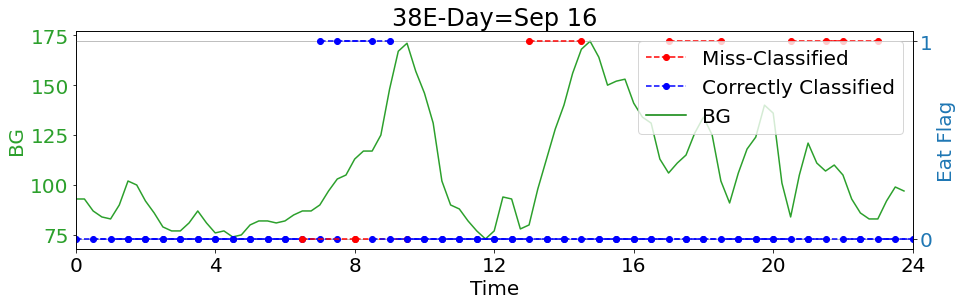

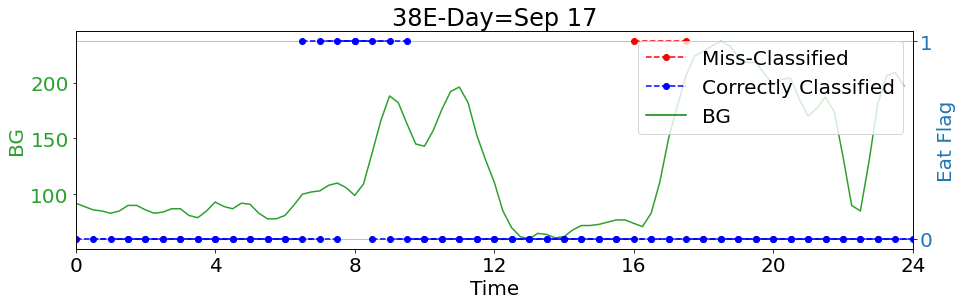

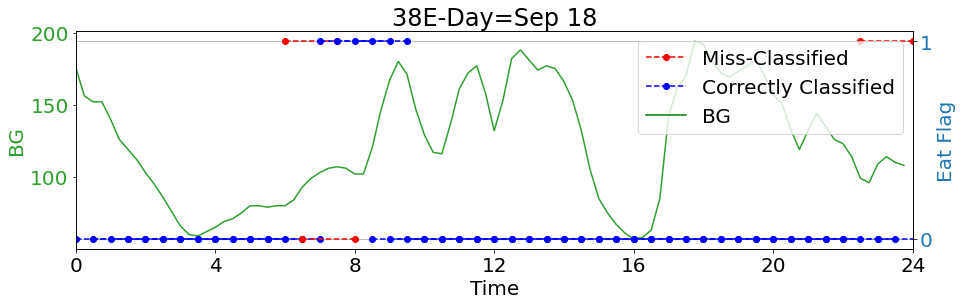

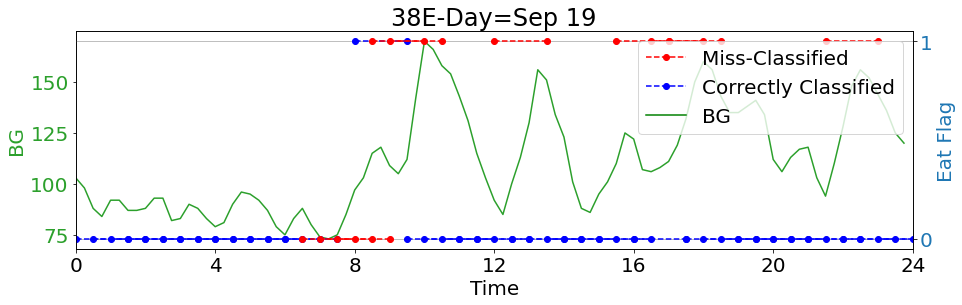

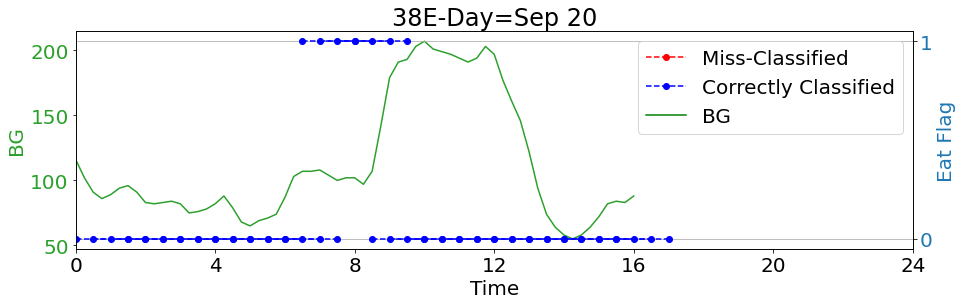

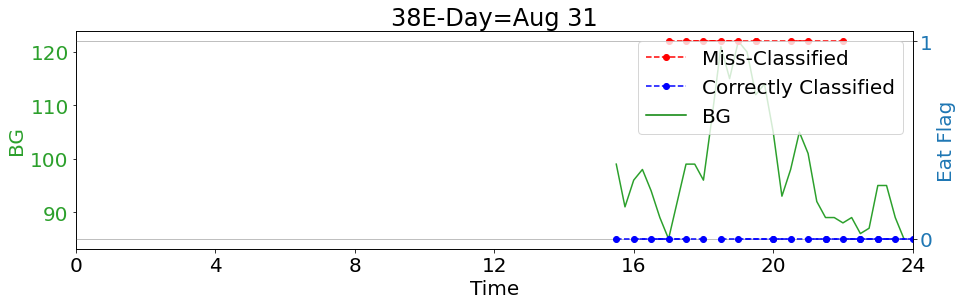

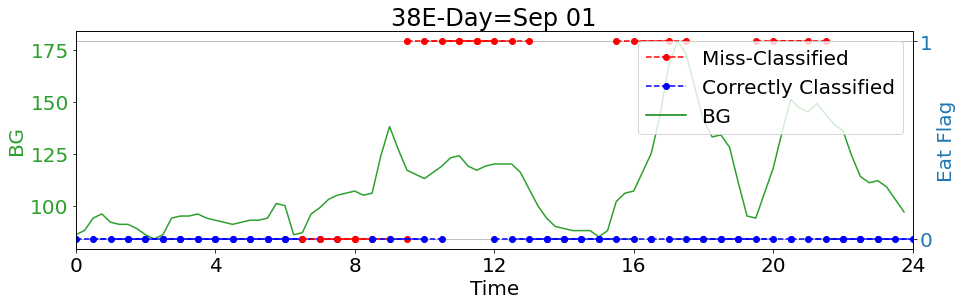

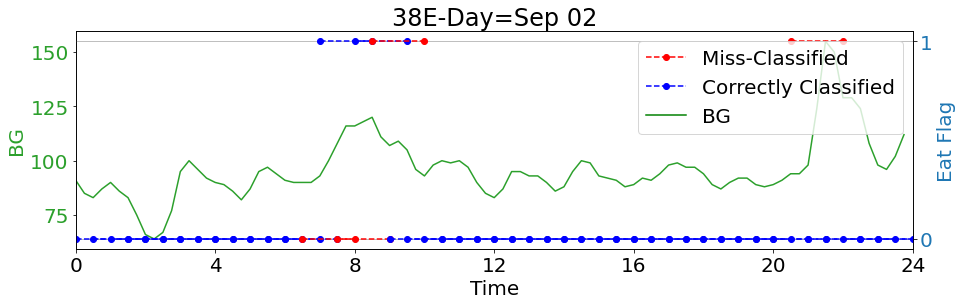

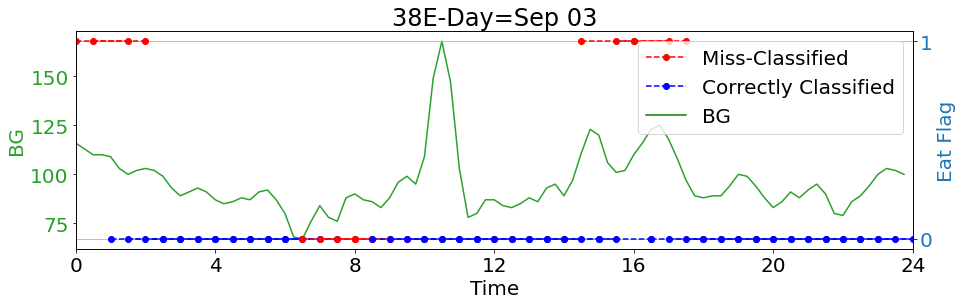

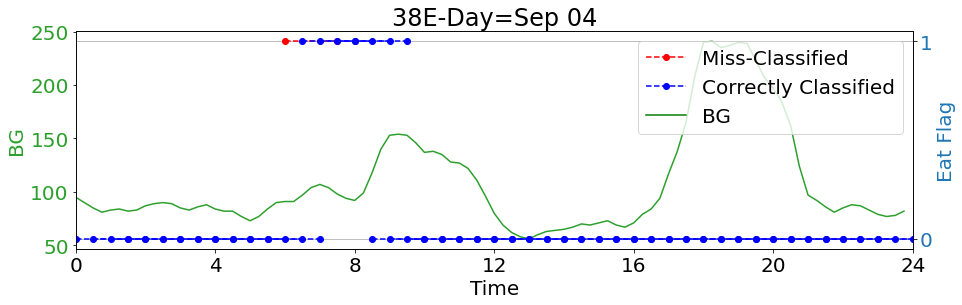

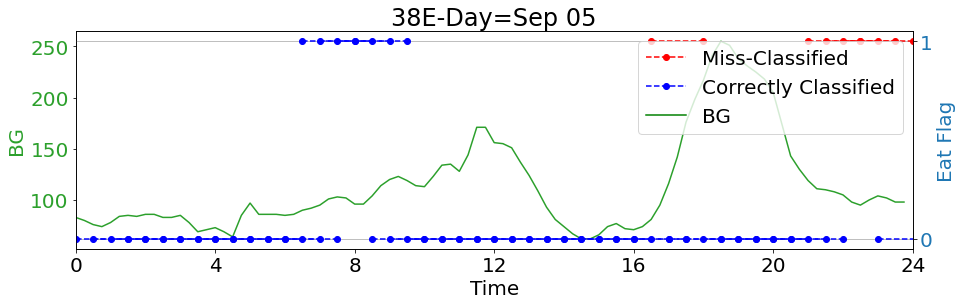

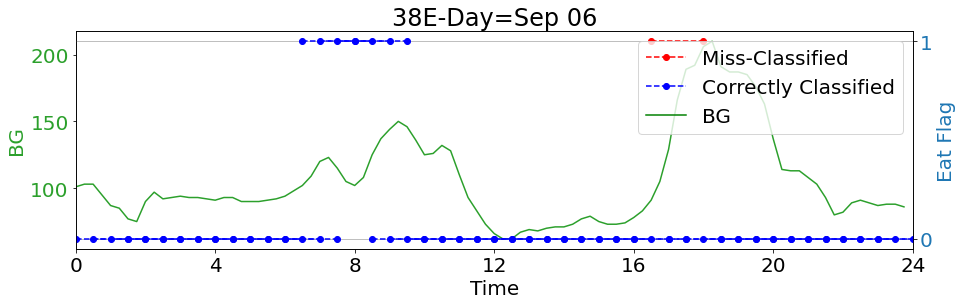

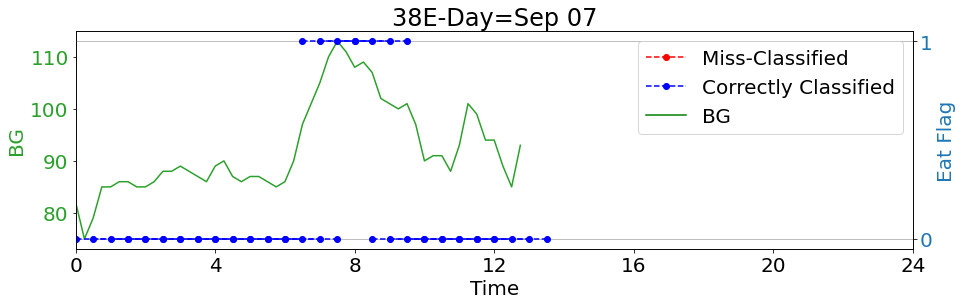

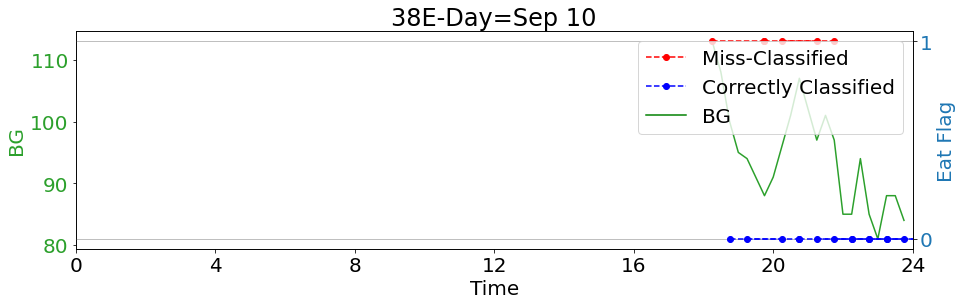

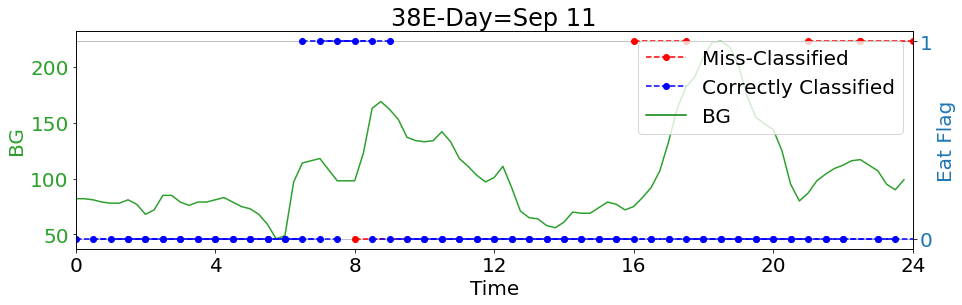

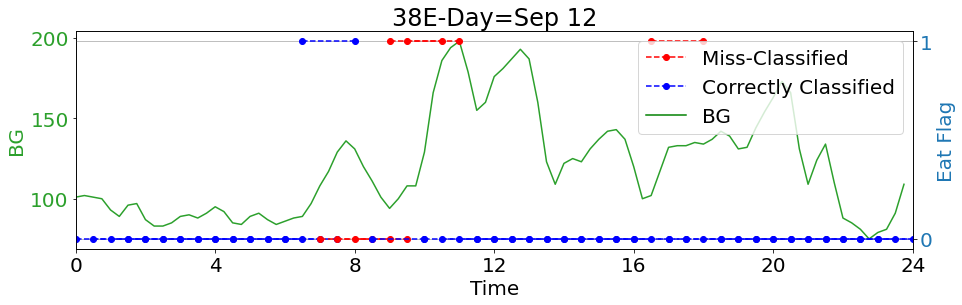

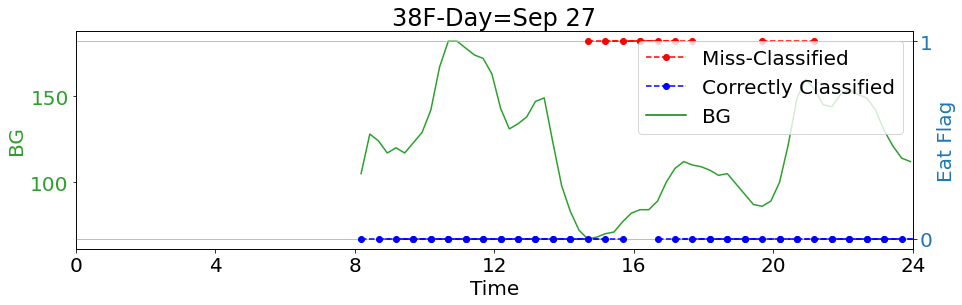

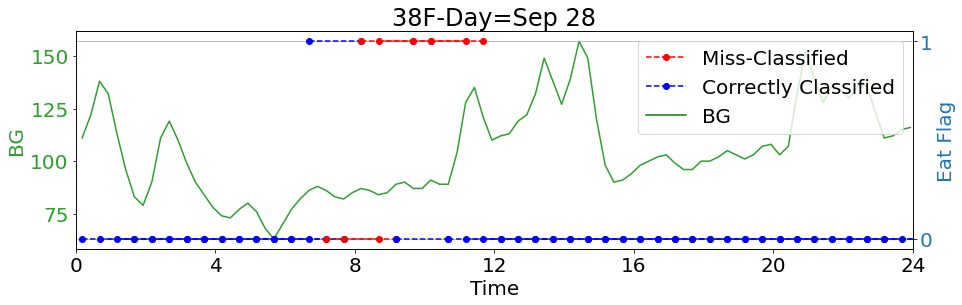

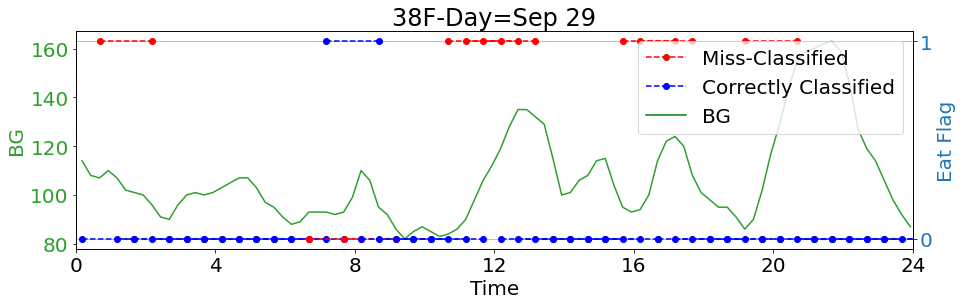

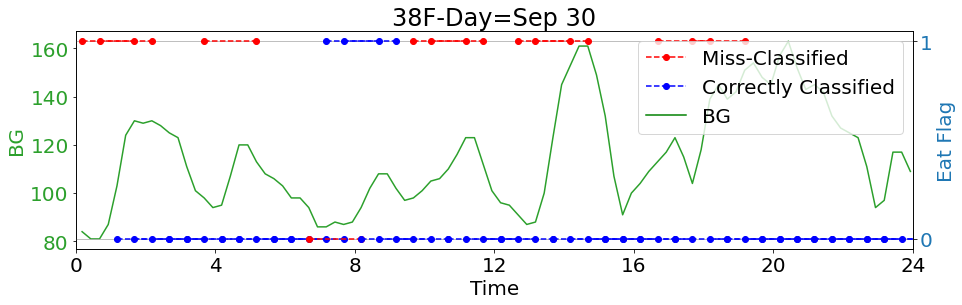

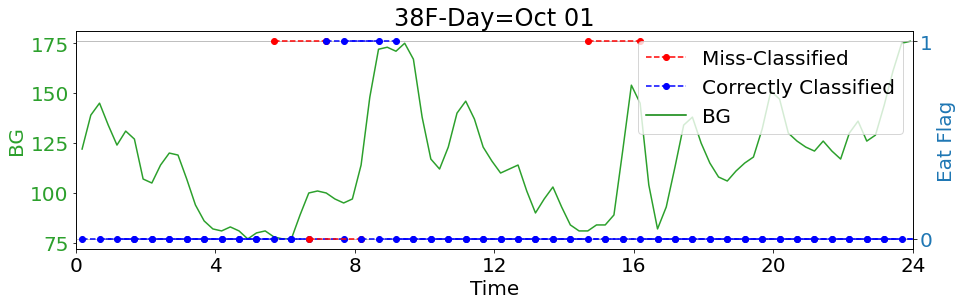

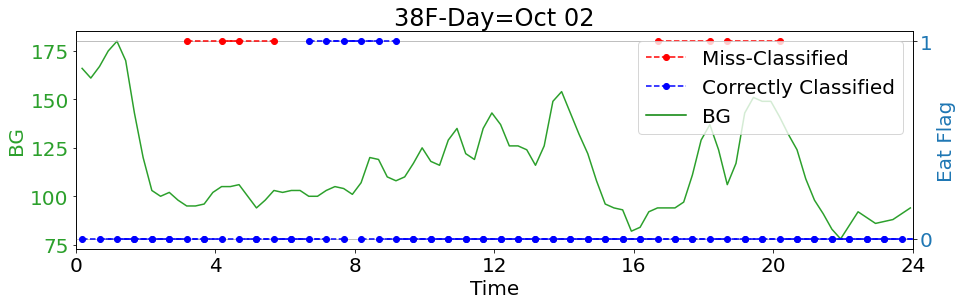

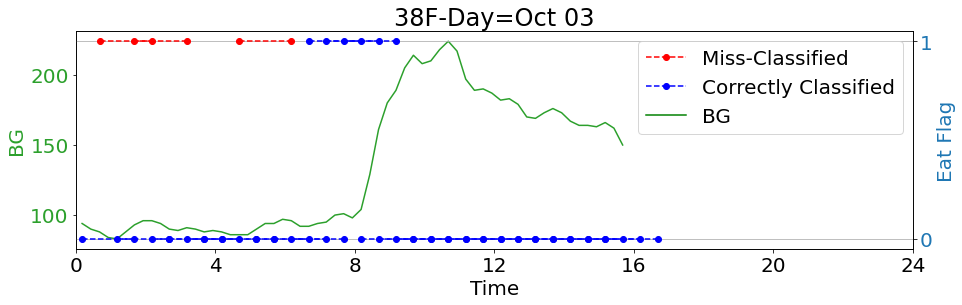

KeyboardInterrupt: 

In [58]:
def windowVisualizerTest(rawData,bestModel,bestThreshold,patientName,sliddingWindow, sliddingWindowLabel, startTime,endTime,days):
    allDays=set(days)
    allDays=list(allDays)
    for dayCounter in range(len(allDays)):
        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==allDays[dayCounter]]

        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 26, 4))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(sliddingWindow.shape[0]):
            if days[counter]==allDays[dayCounter]:
                tempData.append(sliddingWindow[counter,:])
                tempLabel.append(sliddingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        if len(tempData)==0:
            sys.exit(("--------Warning, the slidding window is empty for prediction on day:"+allDays[dayCounter]))

        tempPred=bestModel.predict_proba(tempData)
        tempPred=tempPred[:,1]
        tempPred[tempPred>=bestThreshold]=1
        tempPred[tempPred<bestThreshold]=0

        ax2 = ax1.twinx()
        for counter in range(len(tempPred)):
            if tempPred[counter]==tempLabel[counter]:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='b')
            else:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='r')
        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Miss-Classified')
        ax2.plot([],[],linestyle='--', marker='o', color='b',label='Correctly Classified')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.legend()

        tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
        tempDate=tempDate.strftime("%b %d")
        plt.title(patientName+"-Day="+tempDate,color='black')

        color='tab:blue'
        ax2.set_ylabel('Eat Flag', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 26, 4))

        plt.grid()
        plt.show()

def participantReaderTest(plotFlag,modelingMethod):
    bestThreshold=0.6
    fileAddressRoot="C:\\GitHub\\STMI-CGM\\Processed38\\38-ALL-data-dump\\"

    patientNames=['38A','38B','38C','38D','38E','38F','38H']
    for counter in range(len(patientNames)):
        patientName=patientNames[counter]
        fileName=fileAddressRoot+patientName+"\\"+patientName+"\\"+"all_record_"+patientName+".csv"
        print('Reading.....',patientName)

        sliddingWindowTest,sliddingWindowLabelTest,rawDataTest=csvReader(fileName,False)
        sliddingWindowTest=np.array(sliddingWindowTest,dtype=float)
        sliddingWindowLabelTest=np.array(sliddingWindowLabelTest,dtype=int)

        if modelingMethod=='RF':
            tempModelName="C:\\GitHub\\STMI-CGM\\Sanitized38\\" +"RF"+patientName+".pkl"
            bestModel = pickle.load(open(tempModelName, 'rb'))

            dataPred=bestModel.predict_proba(sliddingWindowTest[:,0:11])
            dataPred=dataPred[:,1]
            dataPred[dataPred>=bestThreshold]=1
            dataPred[dataPred<bestThreshold]=0
            confusionMatrixTest=confusion_matrix(sliddingWindowLabelTest, dataPred)
        if modelingMethod=='XG':
            tempModelName="C:\\GitHub\\STMI-CGM\\Sanitized38\\" +"XG"+patientName+".pkl"
            bestModel = pickle.load(open(tempModelName, 'rb'))

            dataPred=bestModel.predict_proba(sliddingWindowTest[:,0:11])
            dataPred=dataPred[:,1]
            dataPred[dataPred>=bestThreshold]=1
            dataPred[dataPred<bestThreshold]=0
            confusionMatrixTest=confusion_matrix(sliddingWindowLabelTest, dataPred)
        confusionMatrixTest=[['\t','Pred Neg\t','Pred Pos'],['Neg\t',str(confusionMatrixTest[0,0])+"\t\t",
                                         confusionMatrixTest[0,1]],['Pos\t',str(confusionMatrixTest[1,0])
                                                                    +"\t\t",confusionMatrixTest[1,1]]]
        for r in confusionMatrixTest:
            for c in r:
                print(c,end = " ")
            print("\n")

        specificityTest=int(confusionMatrixTest[1][1])/(int(confusionMatrixTest[1][1])+
                                                       int(confusionMatrixTest[1][2]))
        specificityTest=round(specificityTest*100,1)

        sensitivityTest=int(confusionMatrixTest[2][2])/(int(confusionMatrixTest[2][1])+
                                                       int(confusionMatrixTest[2][2]))
        sensitivityTest=round(sensitivityTest*100,1)

        accuracyTest=(int(confusionMatrixTest[1][1])+int(confusionMatrixTest[2][2]))/(int(confusionMatrixTest[1][1])
                                                                                     +int(confusionMatrixTest[1][2])
                                                                                     +int(confusionMatrixTest[2][1])+int(confusionMatrixTest[2][2]))
        accuracyTest=round(accuracyTest*100,1)
        print("Specificity=",specificityTest,"Sensitivity=",sensitivityTest,"Accuracy=",accuracyTest)
        if plotFlag:
            windowVisualizerTest(rawDataTest,bestModel,bestThreshold,patientName,sliddingWindowTest[:,0:11],sliddingWindowLabelTest,sliddingWindowTest[:,11],sliddingWindowTest[:,12],sliddingWindowTest[:,13])

timeWindow=90/60
timeStep=30/60
breakfastTime=8
plotFlag=True
modelingMethod='RF'#XG,RF
participantReaderTest(plotFlag,modelingMethod)

In [ ]:

RF_best_threshold=0.6
# timeWindow=120/60
# timeStep=60/60
# breakfastTime=8
myFiles=os.listdir()

RF_best_model = pickle.load(open(r"C:\GitHub\STMI-CGM\Sanitized38\RF38B.pkl", 'rb'))
fileAddress=r"C:\GitHub\STMI-CGM\38-ALL-data-dump\38B\all_record_38B.csv"

sliddingWindow=[]
sliddingWindowResult=[]
completeSliddingWindow=[]

raw1=pd.read_csv(fileAddress)

raw1['time']= pd.to_datetime(raw1['time'])
raw1['BG']= pd.to_numeric(raw1['BG'])
for myColumn in raw1.columns:
    if myColumn not in ['time','BG','Participant']:
        del raw1[myColumn]

raw1=raw1.dropna()
raw1=raw1.drop_duplicates(subset=['time'], keep='last')

raw1.insert(2, "Day of Year",raw1['time'].dt.dayofyear)
raw1.insert(3, "Time",raw1['time'].dt.hour+raw1['time'].dt.minute/60+raw1['time'].dt.second/3600)
raw1=raw1.drop(columns=['time'])
raw1=raw1.sort_values(['Day of Year', 'Time'], ascending=[True, True])

allDays=raw1['Day of Year'].tolist()
allDays=set(allDays)
allDays=list(allDays)

for dayCounter in range(len(allDays)):
    currentDay=allDays[dayCounter]
    dayQuery=raw1[raw1['Day of Year']==currentDay]
    startTime=dayQuery.iloc[0,2]
    endTime=startTime+timeWindow
    counter=0;
    baseLine=80.0001;

    baseLineQuery=dayQuery[dayQuery['Time']>=3]
    baseLineQuery=baseLineQuery[baseLineQuery['Time']<=6]

    if(not np.isnan(baseLineQuery.BG.mean())):
        baseLine=baseLineQuery.BG.mean()
    else:
        print("The BG base line is not found for",allDays[dayCounter],"and we used 80.0001")
    windowQuery=dayQuery[dayQuery['Time']>=startTime]
    windowQuery=windowQuery[windowQuery['Time']<endTime]
    while len(windowQuery)>=(timeWindow*4/2):
        # if endTime>17:
        #     break #after 4PM the participants go home and they don't hold the criteria anymore
        if startTime<=breakfastTime and endTime>=breakfastTime:
            eatFlag=1
        else:
            eatFlag=0
        integralValue=simps(windowQuery.iloc[:,3]-baseLine,x=windowQuery.iloc[:,2])

        maxSlopeValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        maxSlopeValue=np.max(maxSlopeValue)

        minSlopeValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        minSlopeValue=np.min(minSlopeValue)

        maxConcavityValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        maxConcavityValue=np.gradient(maxConcavityValue,windowQuery.iloc[:,2])
        # maxConcavityValue=maxConcavityValue[1:-2]
        maxConcavityValue=np.max(maxConcavityValue)

        minConcavityValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        minConcavityValue=np.gradient(minConcavityValue,windowQuery.iloc[:,2])
        # minConcavityValue=minConcavityValue[1:-2]
        minConcavityValue=np.min(minConcavityValue)

        patientName=windowQuery.iloc[0,0]
        meanValue=round(windowQuery['BG'].mean()-baseLine,2)
        stdValue=round(windowQuery['BG'].std(),4)
        minValue=round(windowQuery['BG'].min()-baseLine,2)
        maxValue=round(windowQuery['BG'].max()-baseLine,2)
        minSlopeValue=round(minSlopeValue,4)
        maxSlopeValue=round(maxSlopeValue,4)
        integralValue=round(integralValue,4)
        minConcavityValue=round(minConcavityValue,4)
        maxConcavityValue=round(maxConcavityValue,4)

        sliddingWindow.append([meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,integralValue,minConcavityValue,maxConcavityValue])
        sliddingWindowResult.append(eatFlag)
        completeSliddingWindow.append([meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,integralValue,minConcavityValue,maxConcavityValue,startTime,endTime,currentDay,eatFlag])

        startTime+=timeStep
        endTime+=timeStep
        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]

sliddingWindowResult=np.array(sliddingWindowResult,dtype=int)
sliddingWindow=np.array(sliddingWindow,dtype=float)
completeSliddingWindow=np.array(completeSliddingWindow,dtype=float)

for dayCounter in range(len(allDays)):
    fig, ax1 = plt.subplots()
    newQuery=raw1[raw1['Day of Year']==allDays[dayCounter]]
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #     print("ssssssssssssssssssssssss",newQuery)
    color = 'tab:green'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('BG', color=color)
    ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim([0,24])
    ax1.set_xticks(np.arange(0, 26, 4))

    tempData=[]
    for counter in range(completeSliddingWindow.shape[0]):
        if completeSliddingWindow[counter,11]==allDays[dayCounter]:
            tempData.append(completeSliddingWindow[counter,:])
    tempData=np.array(tempData,dtype=float)

    if len(tempData)==0:
        print("--------Warning, the slidding window is empty for prediction on day:",allDays[dayCounter])
        continue

    tempDataResult=tempData[:,-1].astype(int)
    newTemp=tempData[:,0:9]

    tempDataPred=RF_best_model.predict_proba(newTemp)
    tempDataPred=tempDataPred[:,1]
    tempDataPred[tempDataPred>=RF_best_threshold]=1
    tempDataPred[tempDataPred<RF_best_threshold]=0
    newTemp=tempData[:,9:11]

    ax2 = ax1.twinx()
    for counter in range(len(tempDataPred)):
        # ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='c')
        if tempDataPred[counter]==1:
            ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='r')
        if tempDataPred[counter]==0:
            ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='b')
    tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
    tempDate=tempDate.strftime("%b %d")

    plt.title(patientName+"-Day="+tempDate,color='black')

    color='tab:red'
    ax2.set_ylabel('Eat Flag', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_yticks([0,1])
    ax2.set_xlim([0,24])
    ax2.set_xticks(np.arange(0, 26, 4))

    plt.grid()
    plt.show()